# 4. Unsupervised Learning - Clustering
Author: Philip Kalinda

## 4.1 Intro

Here we can leverage data science to cluster customers based on their activity and their orders. This is an unspuervised method as this attempts to define structure amongst the data without labels.

In [60]:
# standards
import numpy as np
import pandas as pd

# vizulaisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
shopColors = ['#EC5D24','#93134A','#F7F5E8','#2B2C30','#336E7B','#F2931A']*2
from matplotlib.colors import LinearSegmentedColormap
cm = LinearSegmentedColormap.from_list('sains', shopColors, N=len(shopColors))
sns.set_palette(shopColors)

# clustering
from scipy.spatial.distance import cdist, pdist, euclidean
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import scale

# settings
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 60)
pd.set_option("display.latex.repr", True)

In [61]:
np.random.seed(np.sum([ord(i) for i in 'Philip Kalinda']))

In [62]:
# raw data
customers = pd.read_csv('datasets/customers.csv',index_col = 0)

## 4.2 Data Describe

First we must treat the data in order to make it suitable for clustering. To do this we will view the structure of the data and transform it to resemble as normal a distribution as possible

In [63]:
customers.describe(include='all')

,customerID,totalShoppingOrders,totalStoreOrders,totalWebOrders,storeOrdersProportion,webOrdersProportion,totalNumberOfItemsPurchased,averageNumberOfItemsPurchasedPerOrder,proportionOfTotalItemsPurchasedOne,totalWeekendOrders,totalWeekdayOrders,WeekendOrdersProportion,WeekdayOrdersProportion,totalItemsPurchasedWeekend,totalItemsPurchasedWeekday,itemsPurchasedWeekendProportion,itemsPurchasedWeekdayProportion,proportionOfProductRangePurchased,ordersPerUniqueProduct,numberOfDifferentStoresPurchased,averageOrdersPerStore,proportionOfOrdersWithRepeatedProductsPurchased,averageUniquenessOfOrder,averageBusyStore,averageProportionOfOrderSizeOfStoreTotal,averageProportionOfOrderDifferenceOfStoreTotal
count,1000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
unique,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,3ac65fe5ab9008ff1ad9905989192c5af915d1fdbed944...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,11.15500,10.824000,0.358000,0.950008,0.051607,142.121000,14.290150,0.758092,2.914000,8.241000,0.270533,0.729467,40.652000,101.469000,0.279881,0.720119,0.004885,0.196555,2.654000,4.941938,0.787732,0.614307,1.550200,0.035659,0.055632
std,NaN,8.08606,8.269063,1.409902,0.193524,0.196485,122.467141,11.096628,0.161237,2.860557,6.430729,0.234383,0.234383,64.677617,100.378757,0.273974,0.273974,0.003593,0.217916,1.518746,4.422931,0.272042,0.208898,0.508505,0.093966,0.140335
min,NaN,1.00000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000058,0.019704,1.000000,0.500000,0.000000,0.000000,0.000000,0.000064,0.000148
25%,NaN,5.00000,5.000000,0.000000,1.000000,0.000000,50.000000,6.108333,0.666667,1.000000,4.000000,0.111111,0.615385,3.000000,30.000000,0.043080,0.591945,0.002015,0.083269,2.000000,2.333333,0.714286,0.459507,1.311298,0.000903,0.002903
50%,NaN,9.00000,9.000000,0.000000,1.000000,0.000000,107.000000,11.087121,0.786344,2.000000,7.000000,0.234314,0.765686,18.000000,70.000000,0.206188,0.793812,0.004117,0.138456,2.000000,3.800000,0.875000,0.601818,1.733333,0.003318,0.009135
75%,NaN,15.00000,14.000000,0.000000,1.000000,0.000000,201.250000,19.000000,0.871083,4.000000,11.000000,0.384615,0.888889,50.000000,146.000000,0.408055,0.956920,0.006909,0.234605,3.000000,6.000000,1.000000,0.768748,2.000000,0.022469,0.048895


Here we can see that there are features that there are no null values

In [64]:
customers[customers.isnull().any(axis=1)==True].shape

(0, 26)

In [66]:
customers.corr()

,totalShoppingOrders,totalStoreOrders,totalWebOrders,storeOrdersProportion,webOrdersProportion,totalNumberOfItemsPurchased,averageNumberOfItemsPurchasedPerOrder,proportionOfTotalItemsPurchasedOne,totalWeekendOrders,totalWeekdayOrders,WeekendOrdersProportion,WeekdayOrdersProportion,totalItemsPurchasedWeekend,totalItemsPurchasedWeekday,itemsPurchasedWeekendProportion,itemsPurchasedWeekdayProportion,proportionOfProductRangePurchased,ordersPerUniqueProduct,numberOfDifferentStoresPurchased,averageOrdersPerStore,proportionOfOrdersWithRepeatedProductsPurchased,averageUniquenessOfOrder,averageBusyStore,averageProportionOfOrderSizeOfStoreTotal,averageProportionOfOrderDifferenceOfStoreTotal
totalShoppingOrders,1.000000,0.986886,-0.014618,0.144992,-0.137148,0.539863,-0.192837,0.085149,0.696325,0.947666,-0.054822,0.054822,0.276187,0.480703,-0.018133,0.018133,0.519879,0.092806,0.381682,0.633927,0.329391,-0.497693,-0.103095,-0.029530,0.015921
totalStoreOrders,0.986886,1.000000,-0.171719,0.279088,-0.271903,0.480669,-0.256938,0.097698,0.687412,0.935141,-0.055306,0.055306,0.249339,0.425783,-0.018217,0.018217,0.477355,0.112439,0.387062,0.618306,0.303209,-0.454963,-0.103365,-0.027612,0.017916
totalWebOrders,-0.014618,-0.171719,1.000000,-0.817517,0.833370,0.318873,0.409774,-0.092815,-0.012711,-0.012727,0.008816,-0.008816,0.135849,0.301509,-0.000081,0.000081,0.216968,-0.133037,-0.064106,0.021252,0.118567,-0.198320,-0.005226,0.005429,-0.005126
storeOrdersProportion,0.144992,0.279088,-0.817517,1.000000,-0.997077,-0.164391,-0.469857,0.125294,0.095555,0.139808,-0.069673,0.069673,-0.080649,-0.148601,-0.051918,0.051918,-0.096753,0.145833,0.159903,0.040014,-0.054457,0.091377,-0.083928,0.024276,0.034337
webOrdersProportion,-0.137148,-0.271903,0.833370,-0.997077,1.000000,0.174132,0.471184,-0.127297,-0.090158,-0.132347,0.069873,-0.069873,0.084457,0.158030,0.051559,-0.051559,0.105103,-0.147447,-0.155849,-0.036876,0.057965,-0.094054,0.076682,-0.017056,-0.029554
totalNumberOfItemsPurchased,0.539863,0.480669,0.318873,-0.164391,0.174132,1.000000,0.566647,-0.109183,0.399519,0.501112,-0.001200,0.001200,0.574778,0.849700,0.026106,-0.026106,0.928719,-0.330130,0.135239,0.407518,0.471623,-0.503968,-0.005879,-0.034384,0.024701
averageNumberOfItemsPurchasedPerOrder,-0.192837,-0.256938,0.409774,-0.469857,0.471184,0.566647,1.000000,-0.216958,-0.101779,-0.197202,0.073504,-0.073504,0.356352,0.461728,0.057196,-0.057196,0.545157,-0.498757,-0.212874,-0.036947,0.318058,-0.119935,0.126627,-0.037152,-0.006874
proportionOfTotalItemsPurchasedOne,0.085149,0.097698,-0.092815,0.125294,-0.127297,-0.109183,-0.216958,1.000000,0.012100,0.101685,-0.089312,0.089312,-0.101104,-0.068064,-0.088810,0.088810,0.038336,0.021271,0.130356,0.001263,-0.045033,0.042873,-0.001518,0.017941,0.041631
totalWeekendOrders,0.696325,0.687412,-0.012711,0.095555,-0.090158,0.399519,-0.101779,0.012100,1.000000,0.430739,0.542563,-0.542563,0.627099,0.083372,0.532110,-0.532110,0.391699,0.039276,0.255119,0.462656,0.226704,-0.342198,-0.065499,-0.029075,0.006193
totalWeekdayOrders,0.947666,0.935141,-0.012727,0.139808,-0.132347,0.501112,-0.197202,0.101685,0.430739,1.000000,-0.310280,0.310280,0.068330,0.567355,-0.259497,0.259497,0.479463,0.099224,0.366448,0.591305,0.313335,-0.473585,-0.100497,-0.024198,0.017264


## 4.3 Data Transformations

Here we can see a number of transformations to see what works best for which variables and from there build a dataset. Having looked at a few transformations, we stick with the log10 transfomation as this resulted in better distributions to choose from.

****************************************************************************************************
totalShoppingOrders


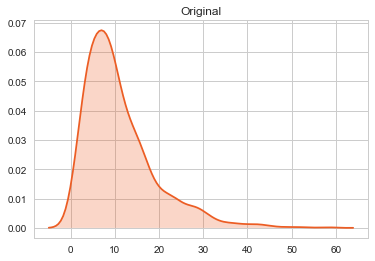

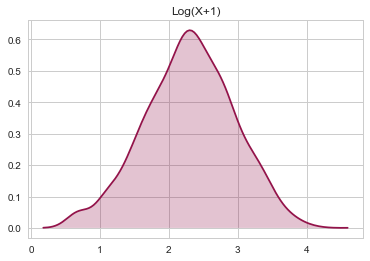

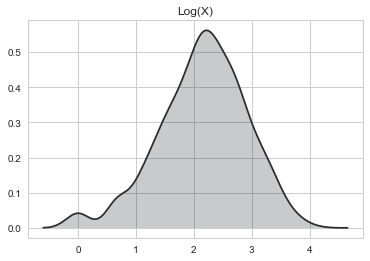

****************************************************************************************************
totalStoreOrders


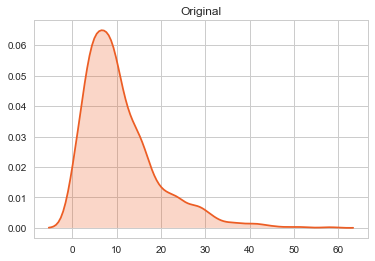

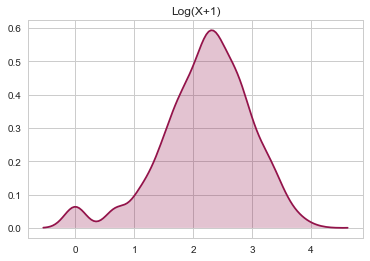

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


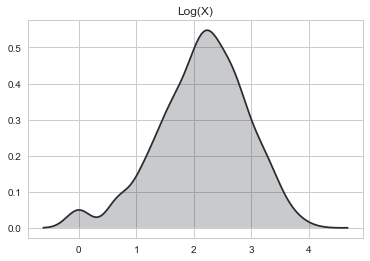

****************************************************************************************************
totalWebOrders


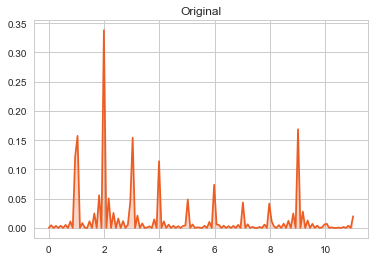

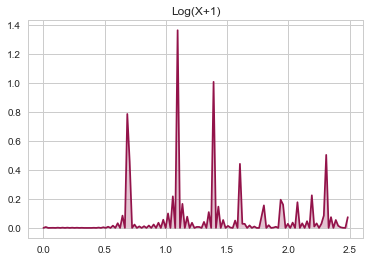

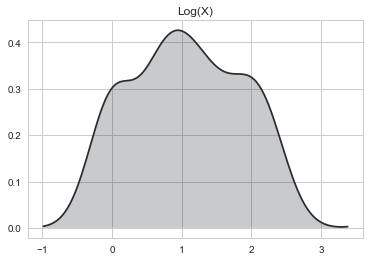

****************************************************************************************************
storeOrdersProportion


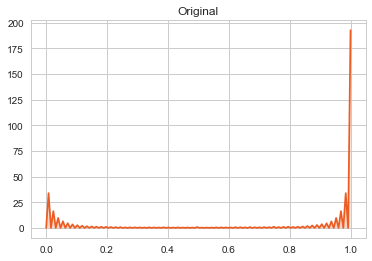

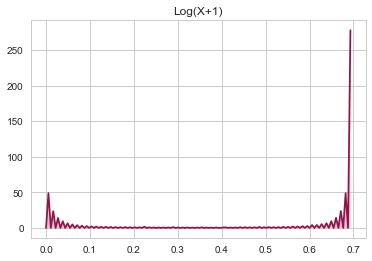

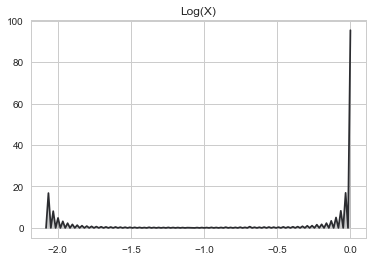

****************************************************************************************************
webOrdersProportion


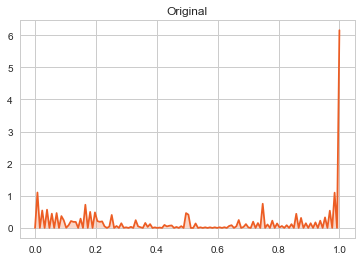

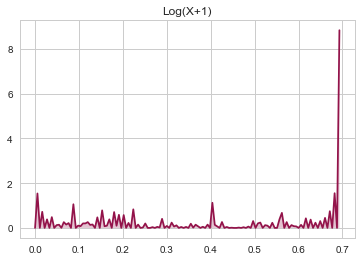

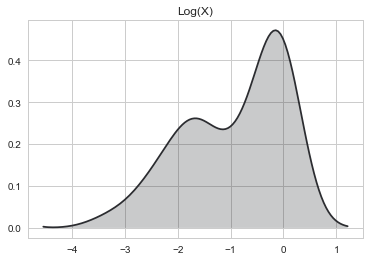

****************************************************************************************************
totalNumberOfItemsPurchased


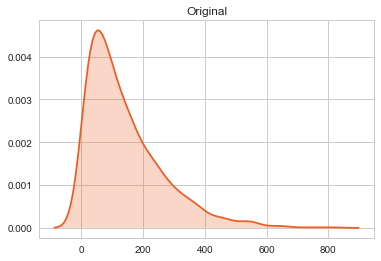

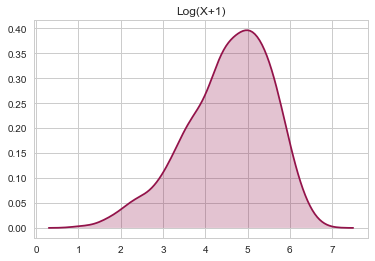

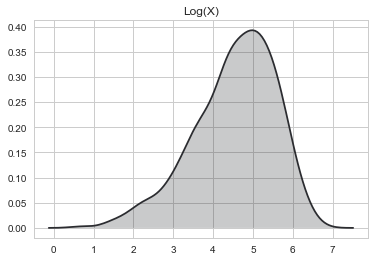

****************************************************************************************************
averageNumberOfItemsPurchasedPerOrder


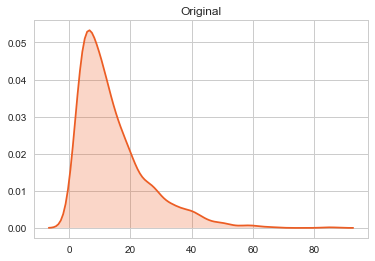

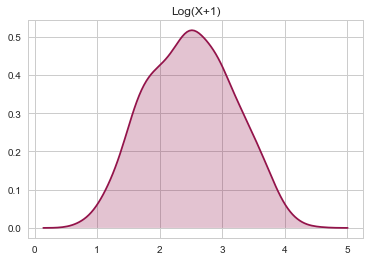

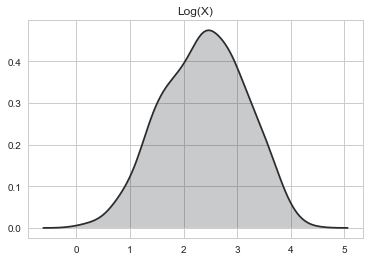

****************************************************************************************************
proportionOfTotalItemsPurchasedOne


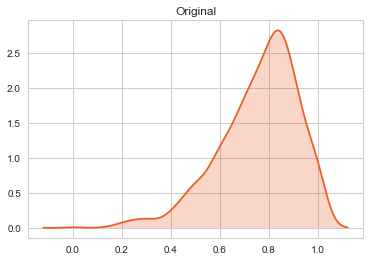

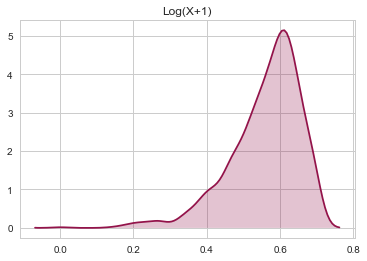

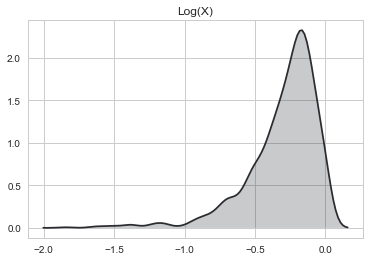

****************************************************************************************************
totalWeekendOrders


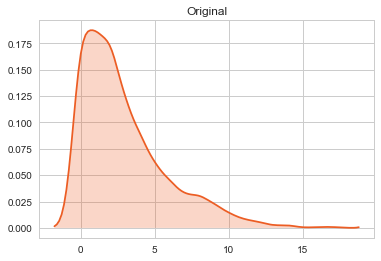

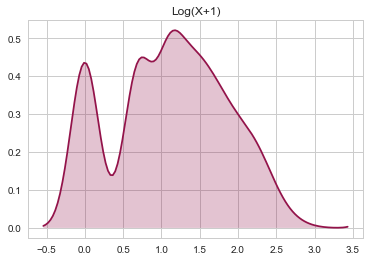

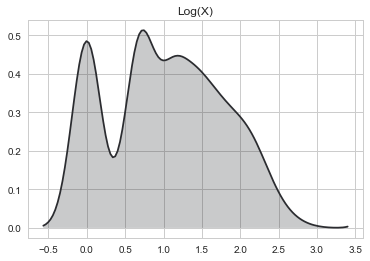

****************************************************************************************************
totalWeekdayOrders


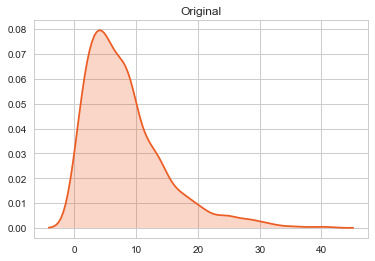

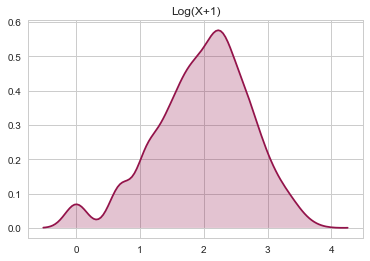

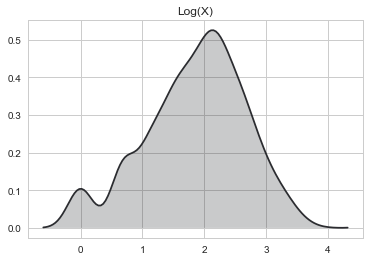

****************************************************************************************************
WeekendOrdersProportion


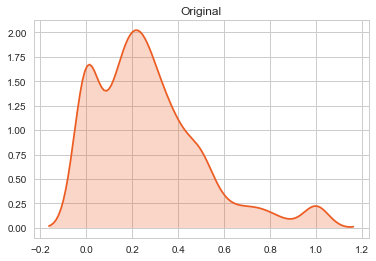

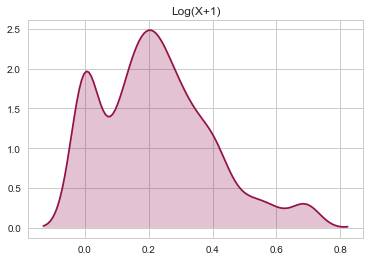

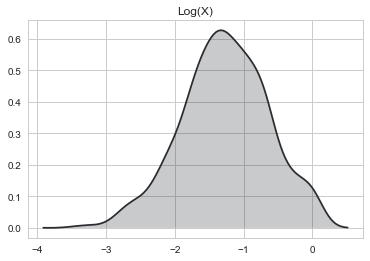

****************************************************************************************************
WeekdayOrdersProportion


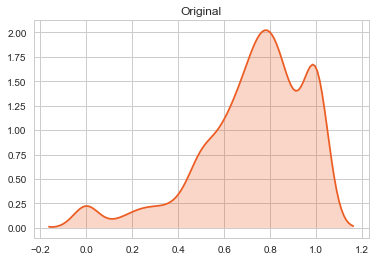

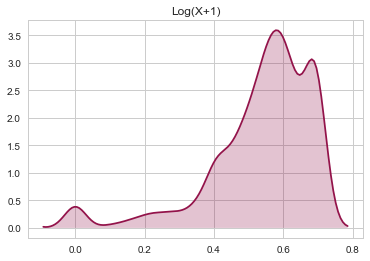

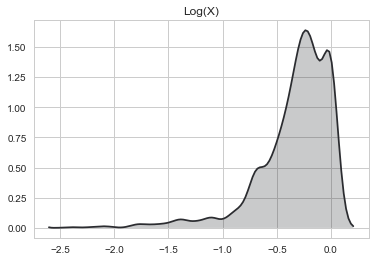

****************************************************************************************************
totalItemsPurchasedWeekend


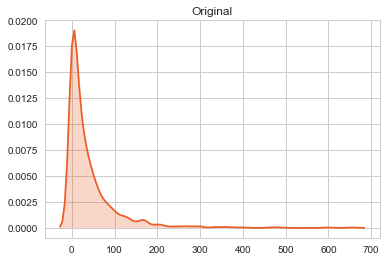

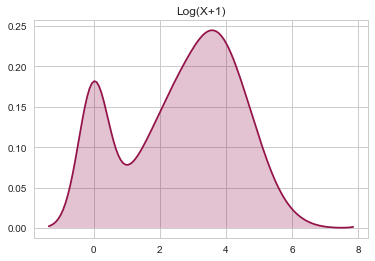

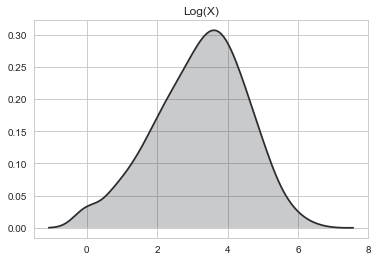

****************************************************************************************************
totalItemsPurchasedWeekday


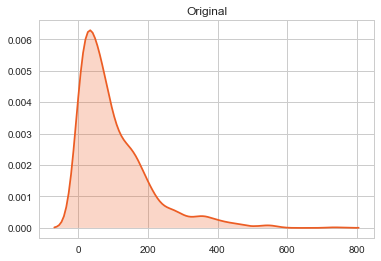

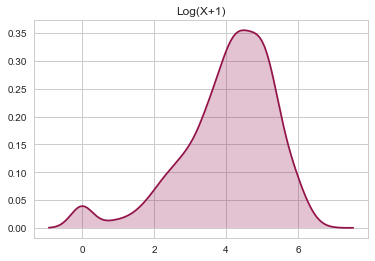

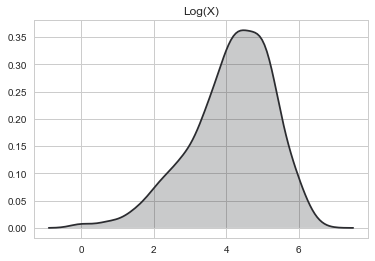

****************************************************************************************************
itemsPurchasedWeekendProportion


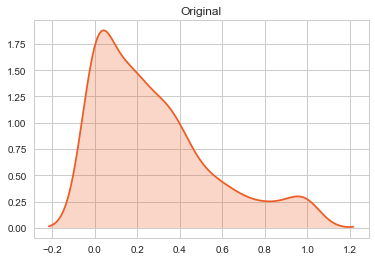

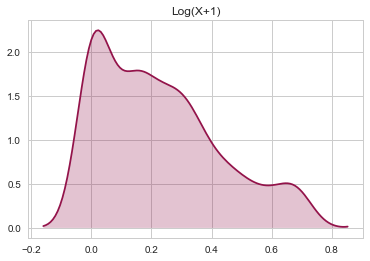

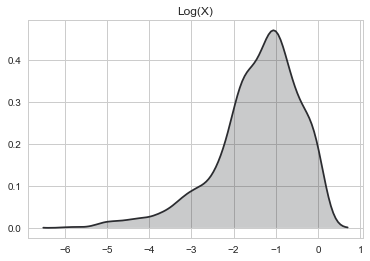

****************************************************************************************************
itemsPurchasedWeekdayProportion


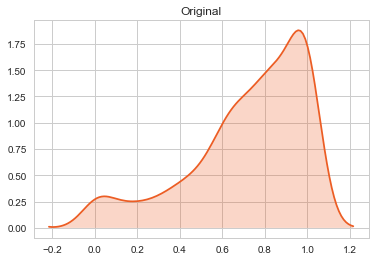

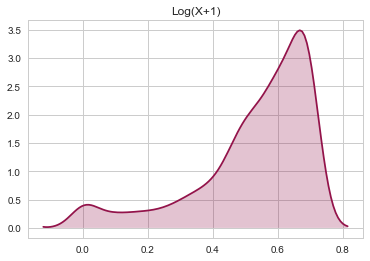

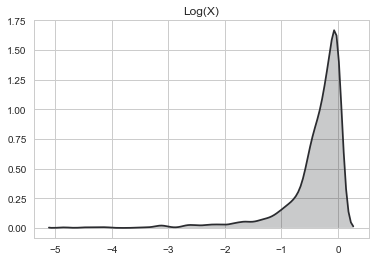

****************************************************************************************************
proportionOfProductRangePurchased


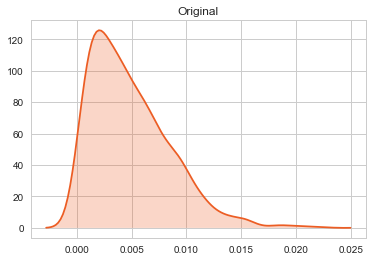

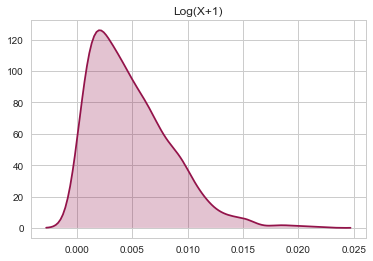

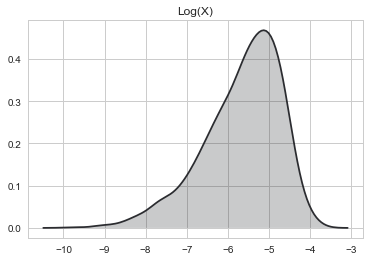

****************************************************************************************************
ordersPerUniqueProduct


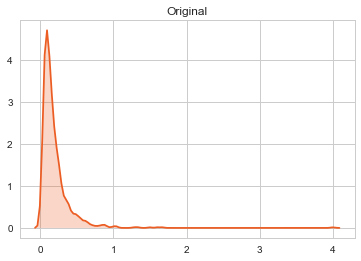

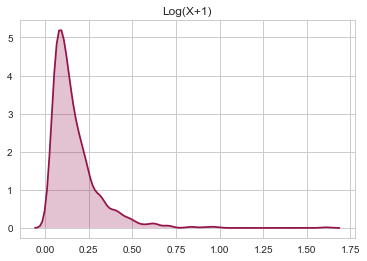

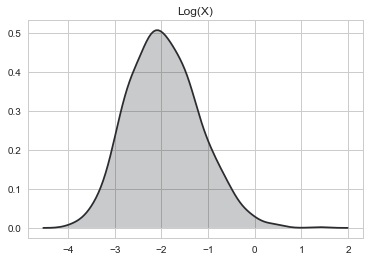

****************************************************************************************************
numberOfDifferentStoresPurchased


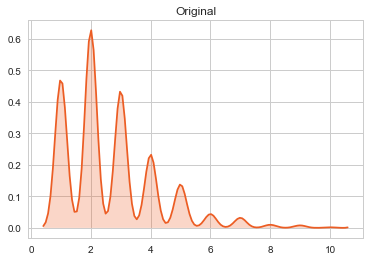

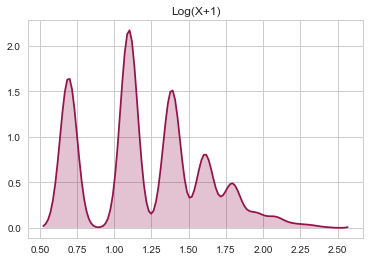

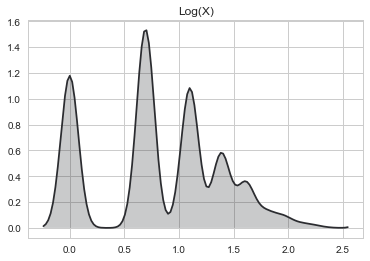

****************************************************************************************************
averageOrdersPerStore


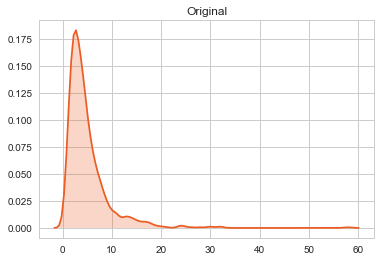

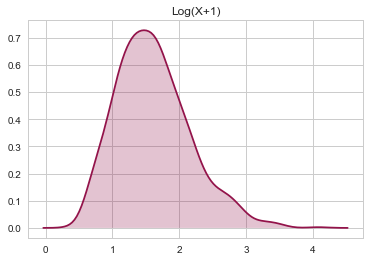

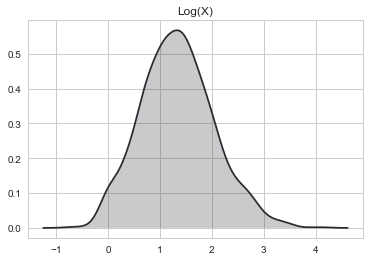

****************************************************************************************************
proportionOfOrdersWithRepeatedProductsPurchased


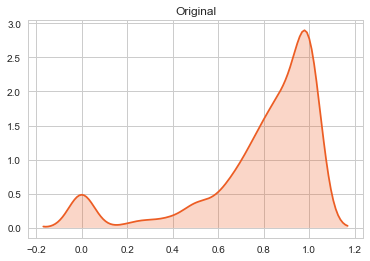

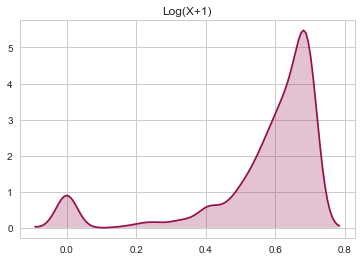

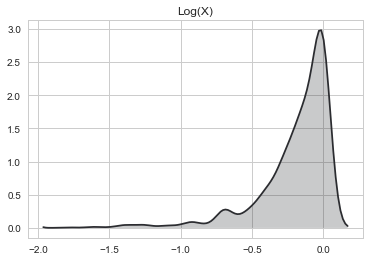

****************************************************************************************************
averageUniquenessOfOrder


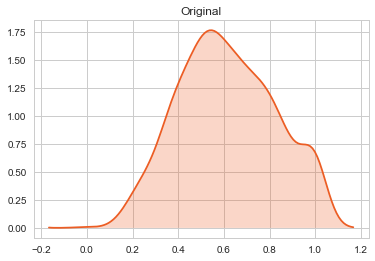

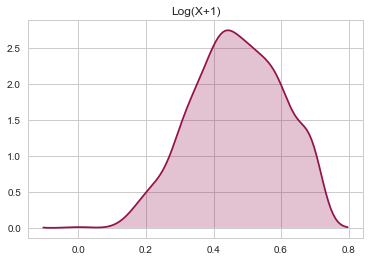

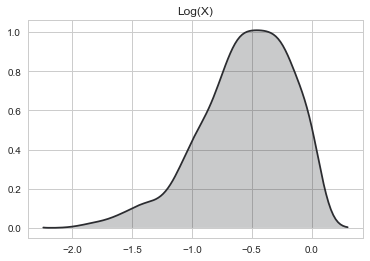

****************************************************************************************************
averageBusyStore


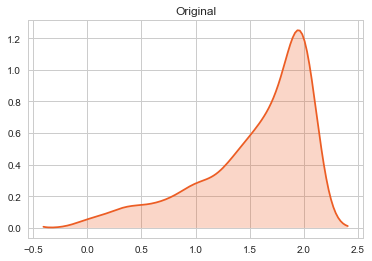

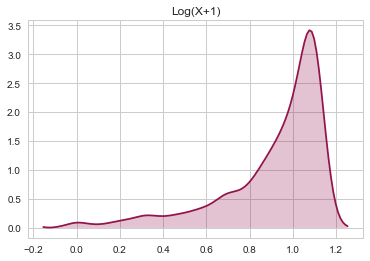

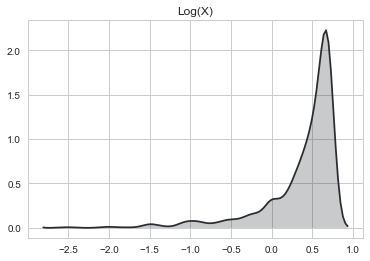

****************************************************************************************************
averageProportionOfOrderSizeOfStoreTotal


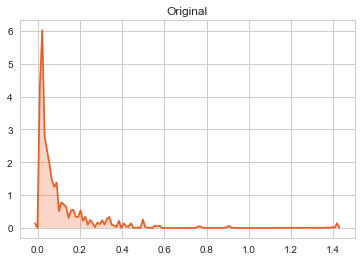

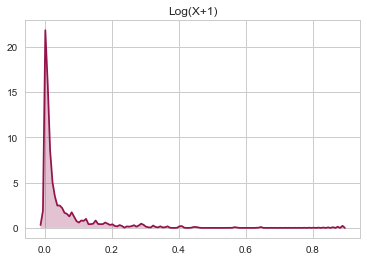

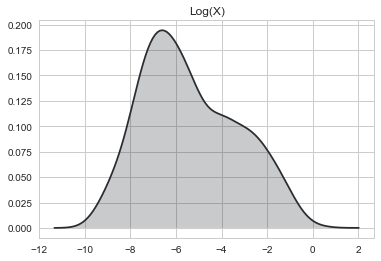

****************************************************************************************************
averageProportionOfOrderDifferenceOfStoreTotal


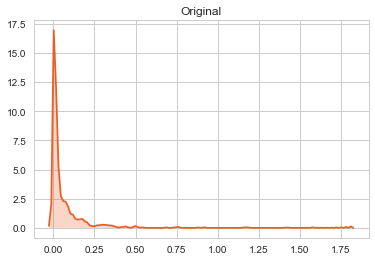

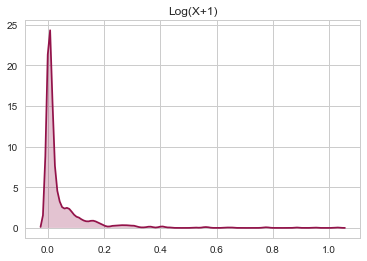

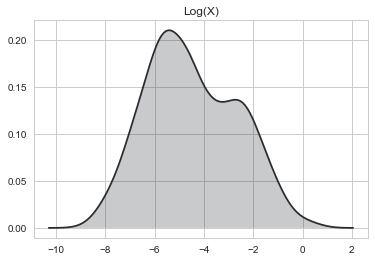

In [6]:
for col in customers.columns[1:]:
    print('*'*100)
    print(col)
    sns.kdeplot(
        (customers[col].values),
        color=shopColors[0],
        shade=True);
    plt.title('Original')
    plt.show()
    sns.kdeplot(
        np.log1p(customers[col].values),
        color=shopColors[1],
        shade=True);
    plt.title('Log(X+1)')
    plt.show()
    sns.kdeplot(
        np.log(customers[col].values),
        color=shopColors[3],
        shade=True);
    plt.title('Log(X)')
    plt.show()

Here we can build a function that can transform the data into a more suitable state for clustering. We build a function because these transformations may be useful in other areas when dealing with customer data and may need to be called again or added to a pipeline.

In [67]:
def transformCustomerData(df):
    """
    df = original dataframe of features aggregated to a customer level.
    
    RETURNS
    Returns a dataframe with transformed variables
    """
    d = df.copy()
    uID = ['customerID']
    logOne = ['totalShoppingOrders','totalStoreOrders',
              'totalWebOrders','proportionOfTotalItemsPurchasedOne',
              'totalWeekdayOrders','WeekendOrdersProportion',
              'totalItemsPurchasedWeekend','totalItemsPurchasedWeekday',
              'itemsPurchasedWeekendProportion','proportionOfProductRangePurchased',
              'averageUniquenessOfOrder'] 
    log = ['totalNumberOfItemsPurchased','averageNumberOfItemsPurchasedPerOrder',
           'ordersPerUniqueProduct','averageOrdersPerStore',
           'averageProportionOfOrderSizeOfStoreTotal','averageProportionOfOrderDifferenceOfStoreTotal']
    toDrop = [i for i in df.columns if i not in uID+logOne+log]
    for col in logOne:
        d[col] = np.log1p(d[col])
    for col in log:
        d[col] = np.log(d[col])
    return d.loc[:,uID+logOne+log]
    

In [68]:
clustCustomers = transformCustomerData(customers)
clustCustomers.head()
mainColoumns = clustCustomers.columns

In [69]:
clustCustomers.corr()

,totalShoppingOrders,totalStoreOrders,totalWebOrders,proportionOfTotalItemsPurchasedOne,totalWeekdayOrders,WeekendOrdersProportion,totalItemsPurchasedWeekend,totalItemsPurchasedWeekday,itemsPurchasedWeekendProportion,proportionOfProductRangePurchased,averageUniquenessOfOrder,totalNumberOfItemsPurchased,averageNumberOfItemsPurchasedPerOrder,ordersPerUniqueProduct,averageOrdersPerStore,averageProportionOfOrderSizeOfStoreTotal,averageProportionOfOrderDifferenceOfStoreTotal
totalShoppingOrders,1.000000,0.904305,-0.029748,0.095453,0.881274,-0.015681,0.455420,0.586197,0.019231,0.558692,-0.575148,0.655499,-0.095835,0.233571,0.696110,0.178401,0.208986
totalStoreOrders,0.904305,1.000000,-0.389730,0.125218,0.800651,-0.016385,0.387764,0.462598,0.015519,0.426619,-0.423358,0.488116,-0.224517,0.310116,0.581838,0.158715,0.189394
totalWebOrders,-0.029748,-0.389730,1.000000,-0.095820,-0.038325,0.018601,0.073413,0.169922,0.005524,0.234452,-0.174648,0.253821,0.363658,-0.282871,0.040456,0.057566,0.042327
proportionOfTotalItemsPurchasedOne,0.095453,0.125218,-0.095820,1.000000,0.116458,-0.081699,-0.065753,-0.002227,-0.080568,0.056830,0.038138,-0.095559,-0.219115,0.022469,-0.011435,-0.013973,0.048813
totalWeekdayOrders,0.881274,0.800651,-0.038325,0.116458,1.000000,-0.446203,0.108378,0.764080,-0.374684,0.464104,-0.487564,0.541276,-0.129886,0.242463,0.597586,0.157750,0.184741
WeekendOrdersProportion,-0.015681,-0.016385,0.018601,-0.081699,-0.446203,1.000000,0.713107,-0.496646,0.898164,0.019580,0.027123,0.017650,0.036513,-0.035931,-0.023496,0.021227,0.015013
totalItemsPurchasedWeekend,0.455420,0.387764,0.073413,-0.065753,0.108378,0.713107,1.000000,0.046978,0.757845,0.465718,-0.228006,0.492115,0.213590,-0.147116,0.311899,0.153178,0.155749
totalItemsPurchasedWeekday,0.586197,0.462598,0.169922,-0.002227,0.764080,-0.496646,0.046978,1.000000,-0.509703,0.658927,-0.380781,0.750542,0.424798,-0.319787,0.451230,0.172113,0.195681
itemsPurchasedWeekendProportion,0.019231,0.015519,0.005524,-0.080568,-0.374684,0.898164,0.757845,-0.509703,1.000000,0.040698,0.014990,0.034678,0.026564,-0.024864,-0.000767,0.031859,0.026658
proportionOfProductRangePurchased,0.558692,0.426619,0.234452,0.056830,0.464104,0.019580,0.465718,0.658927,0.040698,1.000000,-0.348440,0.866140,0.613172,-0.534159,0.432710,0.193236,0.224972


## 4.4 Principal Component Analysis & Scaling

Here we can look to reduce the dimensionality of the dataset and scale it. We scale the data to centre the data around zero. We have already added transformations to the data dealing with the skew of the data.

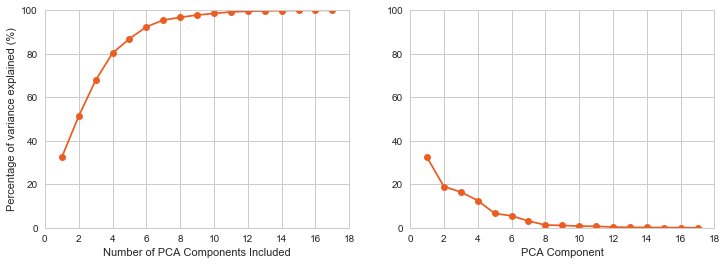

In [9]:
X = clustCustomers.iloc[:,1:].as_matrix()
X = scale(X)

pca = PCA()
pca.fit(X) 
varExpl = pca.explained_variance_ratio_ 
totVarExpl = np.array(
    [sum(varExpl[0:i+1]) for i,x in enumerate(varExpl)]
) 

plt.figure(figsize=(12,4)) 
plt.subplot(1,2,1)
plt.plot(range(1,len(totVarExpl)+1), totVarExpl*100,'o-')
plt.axis([0, len(totVarExpl)+1, 0, 100])
plt.xlabel('Number of PCA Components Included')
plt.ylabel('Percentage of variance explained (%)')

plt.subplot(1,2,2)
plt.plot(range(1,len(varExpl)+1), varExpl*100,'o-')
plt.axis([0, len(varExpl)+1, 0, 100])
plt.xlabel('PCA Component');

Here we can see that the elbow of the graph is at around 4 and 5 components. We will continue our analysis using 4-components.

## 4.5 K-Means Clustering

Here we will use our first clustering algorithm, K-Means. K-Means requires that you choose the number of clusters for it to cluster the data into. Her we can create a number of plots that take into account the inter-cluster distances as well as the intra-cluster distances so we can choose the optimal number of K. We will be looking to choose a number high enough to account for a lot of variance but also small enough to generate meaningful insights from the analysis.

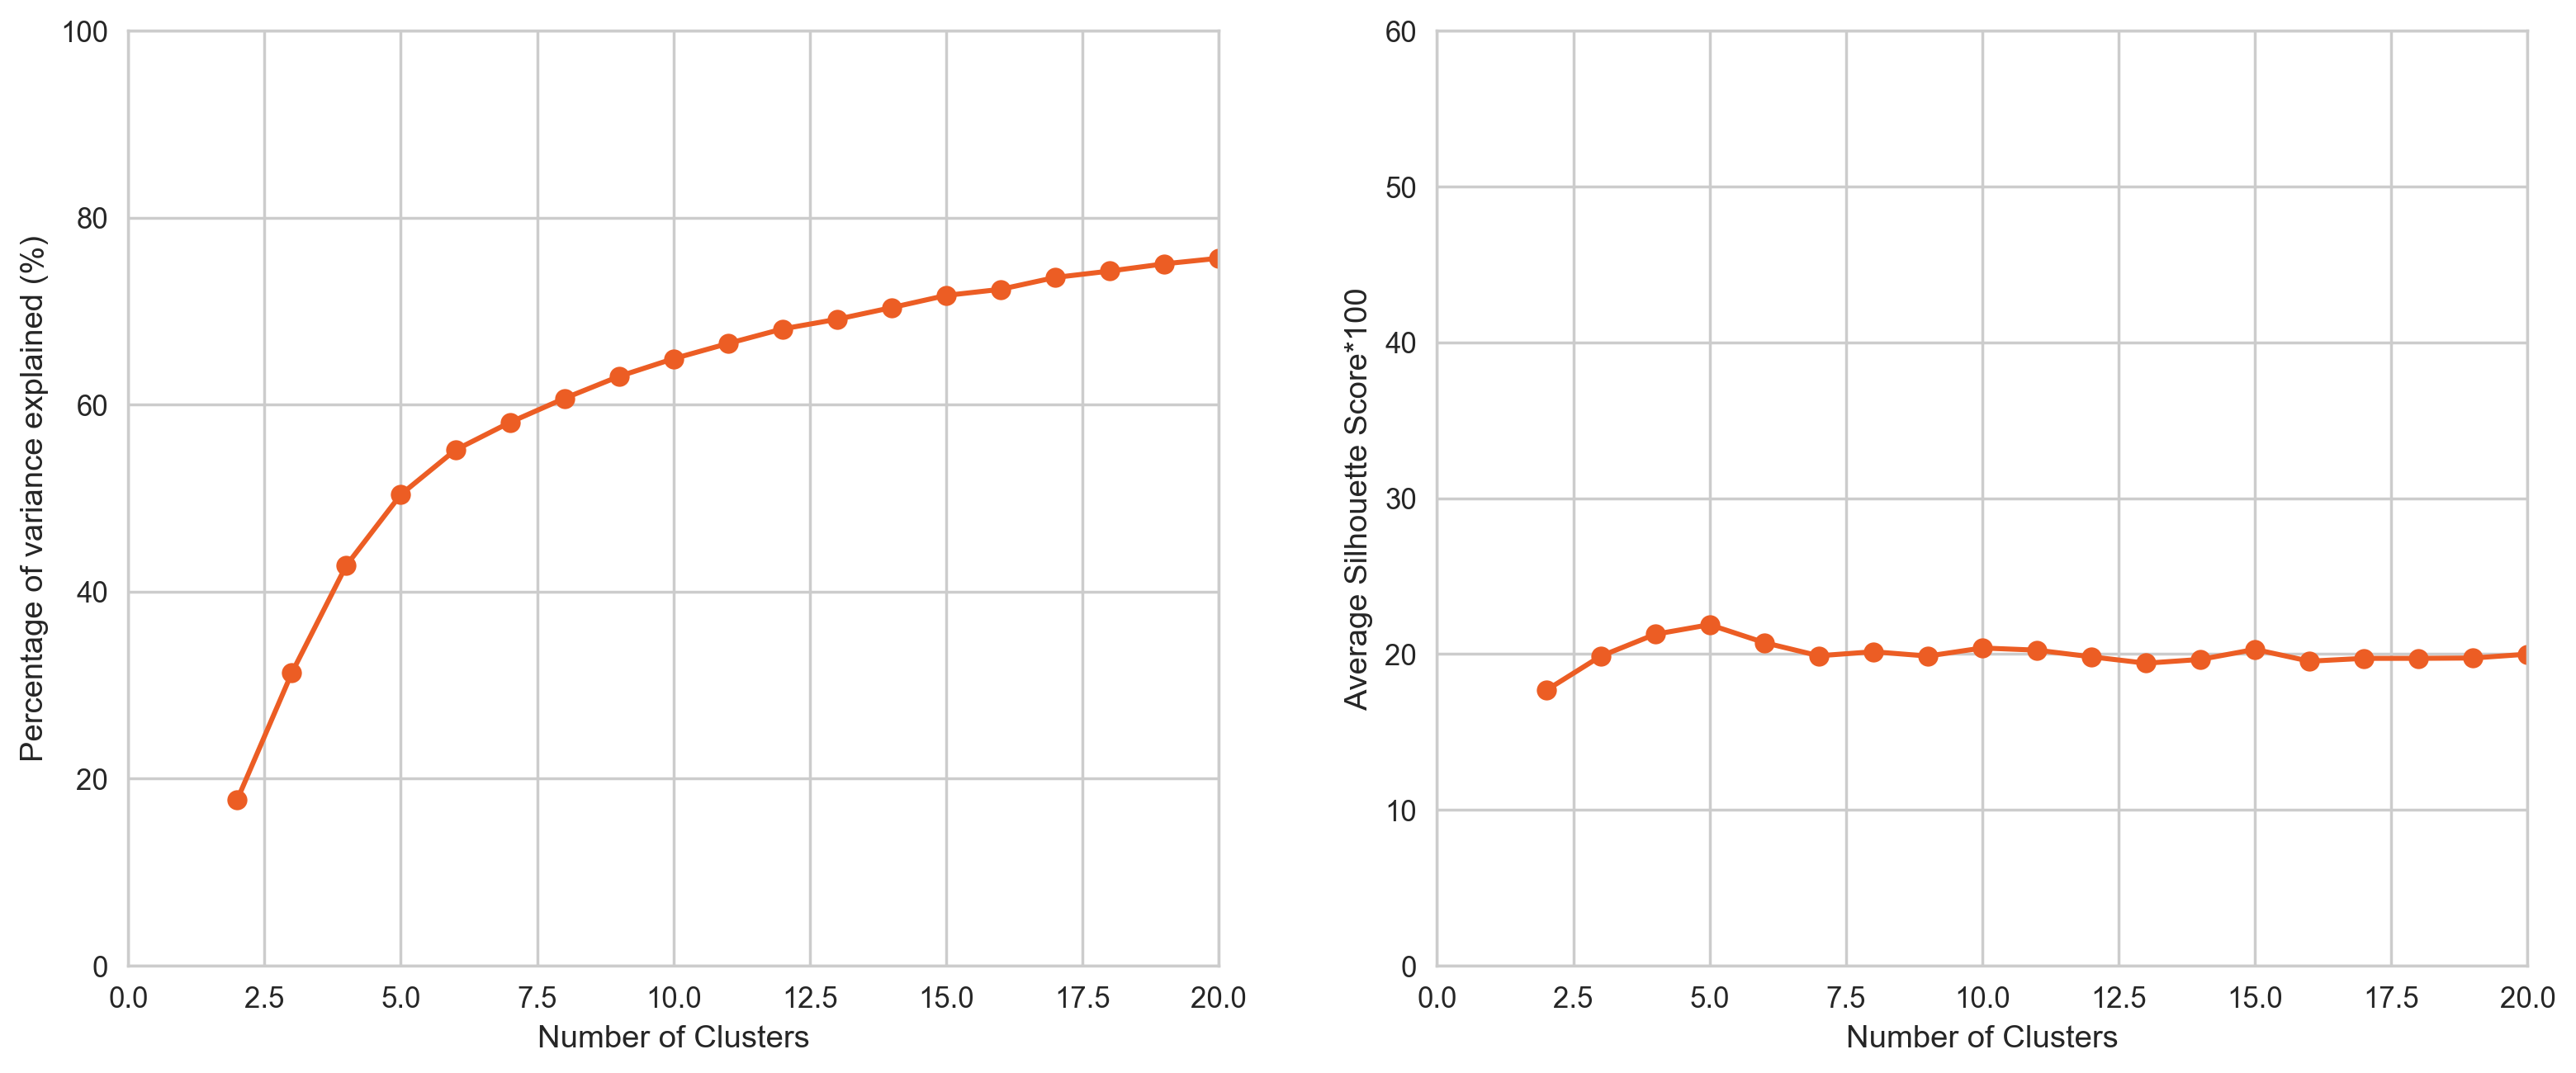

In [10]:
reducedData = PCA(n_components=4, whiten=True).fit_transform(X)

kRange = range(2,21)
kMeansVar = [KMeans(n_clusters=k).fit(reducedData) for k in kRange]

labels = [i.labels_ for i in kMeansVar]
silScore = [metrics.silhouette_score(reducedData,i,metric='euclidean') for i in labels]

centroids = [i.cluster_centers_ for i in kMeansVar]
kEuclid = [cdist(reducedData,cent,'euclidean') for cent in centroids] 
dist = [np.min(ke,axis=1) for ke in kEuclid] 

wcss = [sum(d**2) for d in dist] 
tss = sum(pdist(reducedData)**2/reducedData.shape[0]) 
bss = tss-wcss 

plt.clf()
plt.figure(figsize=(15,6),dpi=250) 
plt.subplot(1,2,1)
plt.plot(kRange, bss/tss*100,'o-')
plt.axis([0, np.max(kRange), 0, 100])
plt.xlabel('Number of Clusters')
plt.ylabel('Percentage of variance explained (%)');

plt.subplot(1,2,2) 
plt.plot(kRange, np.transpose(silScore)*100,'o-')
plt.axis([0, np.max(kRange), 0, 60])
plt.xlabel('Number of Clusters');
plt.ylabel('Average Silhouette Score*100');

Based on the plots above we can see that at 5 clusters we get the highest silhouette score and the percentage of variance begins to plateau. Moving forward we will use 5 clusters. 

Below we can see that the data is distributed well amongst the 5 clusters.

In [11]:
pd.Series(kMeansVar[3].labels_).value_counts()

2    236
1    214
3    210
0    208
4    132
dtype: int64

Here we can visualise the clusters with respect to the 4 components from the PCA stage. 

Here we can see that the clusters are fairly well separated with respect to certain components, however, cluster 0 appears to get lost amongst the other clusters. We will later conduct additional tests to see whether the difference in means for this cluster are statistically / honestly different.

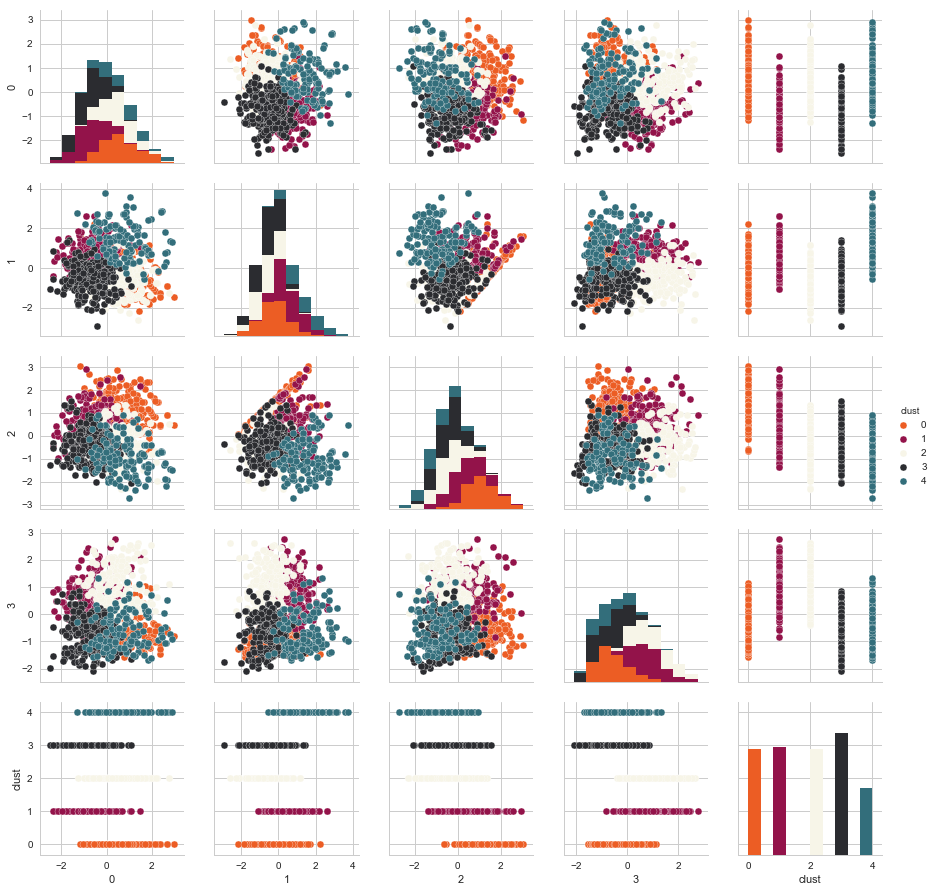

In [12]:
pairdata = pd.DataFrame(PCA(n_components=4, whiten=True).fit_transform(X))
pairdata['clust'] = KMeans(n_clusters=5).fit(pairdata).labels_
sns.pairplot(pairdata,hue='clust')

## 4.6 Hierarchical Clustering

Hierarchical clustering is another clustering algorithm that begins by clustering items from the bottom up, starting with the two closest points and clustering them together, then the next closest clusters and working up from there.

Here we can produce a dendrogram which can help identify how many clusters we must cluster by, as Hierarchcial, like K-Means, requires that you select the number of clusters prior to running the algorithm.

Z.shape:  (999, 4)


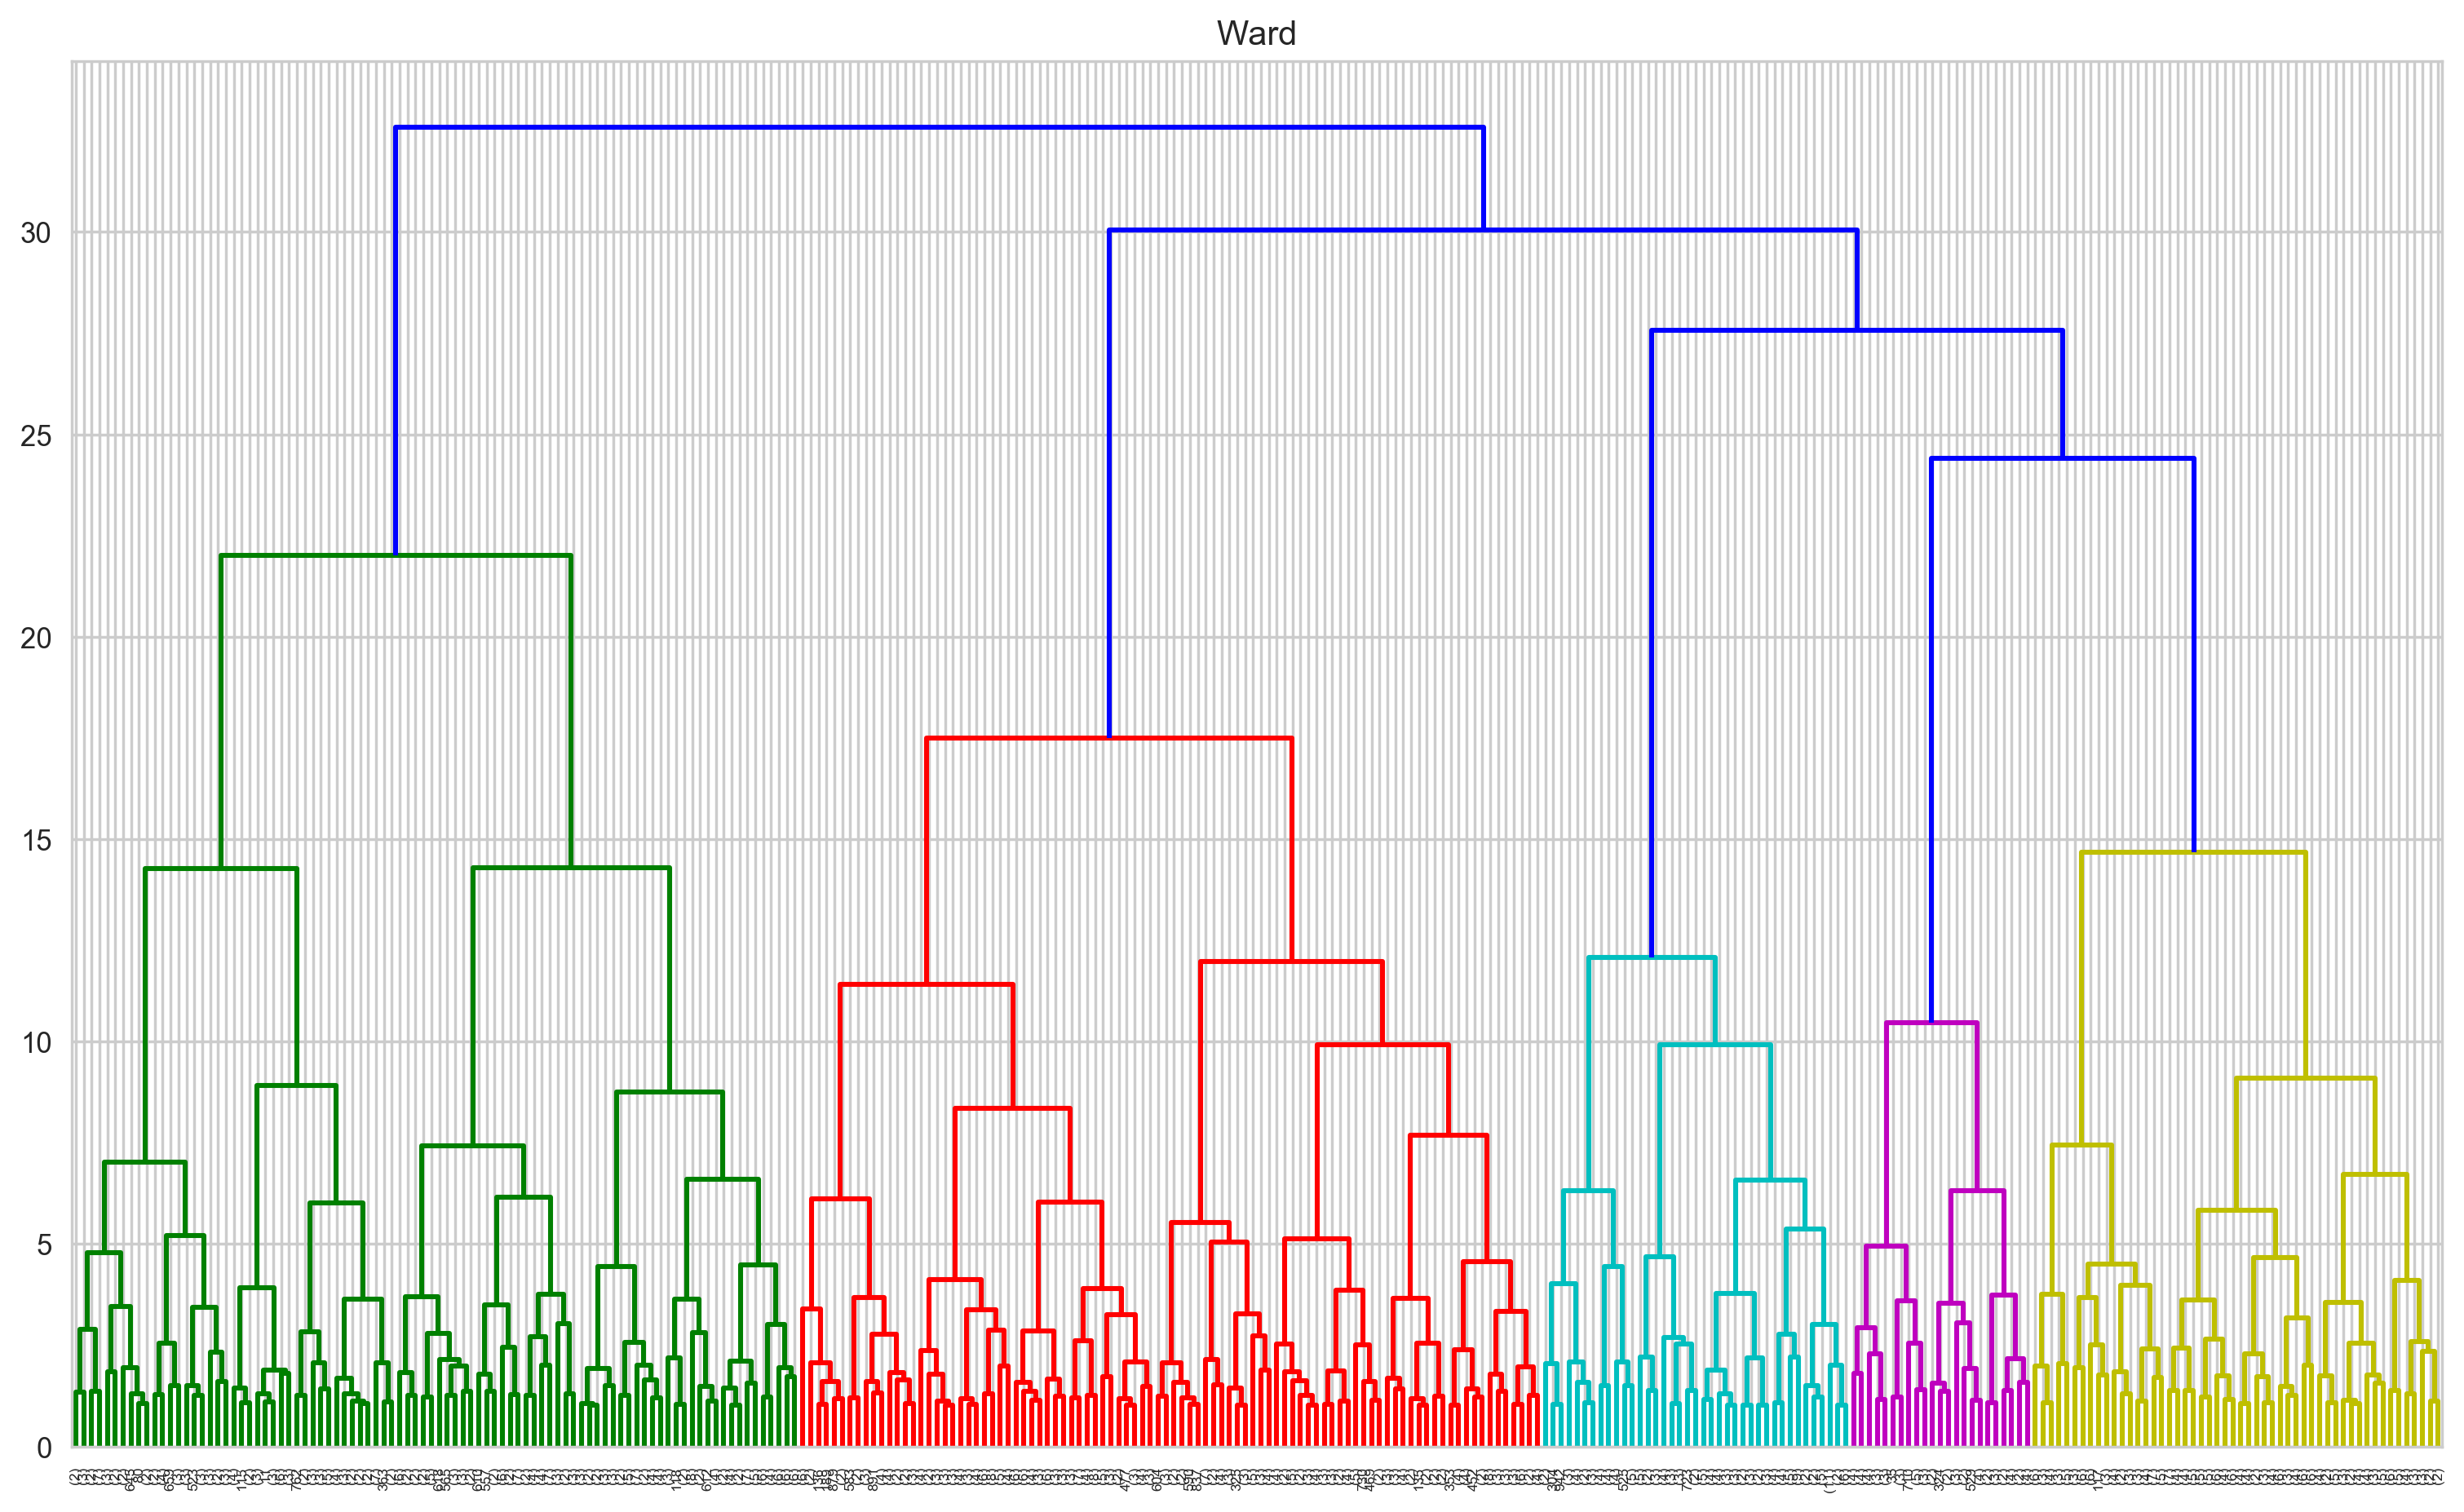

In [13]:
plt.figure(figsize=(15,9),dpi=250)

hdata = PCA(n_components=4, whiten=True).fit_transform(X)

Z = linkage(hdata, 'ward')
print("Z.shape: ", Z.shape)
plt.title("Ward")
dendrogram(Z,p=300, truncate_mode='lastp')
plt.show()

Here we can see that there e are 5 well defined clusters. The dendrogram appears to show that there are 2 larger clusters, 1 medium sized cluster and 2 smaller clusters.

Here we can visualise the clusters with respect to the 4 components from the PCA stage. 

Here we can see that the clusters are not as well separated than the K-Means algorithm, suggesting that this approach may not be the best for this data.

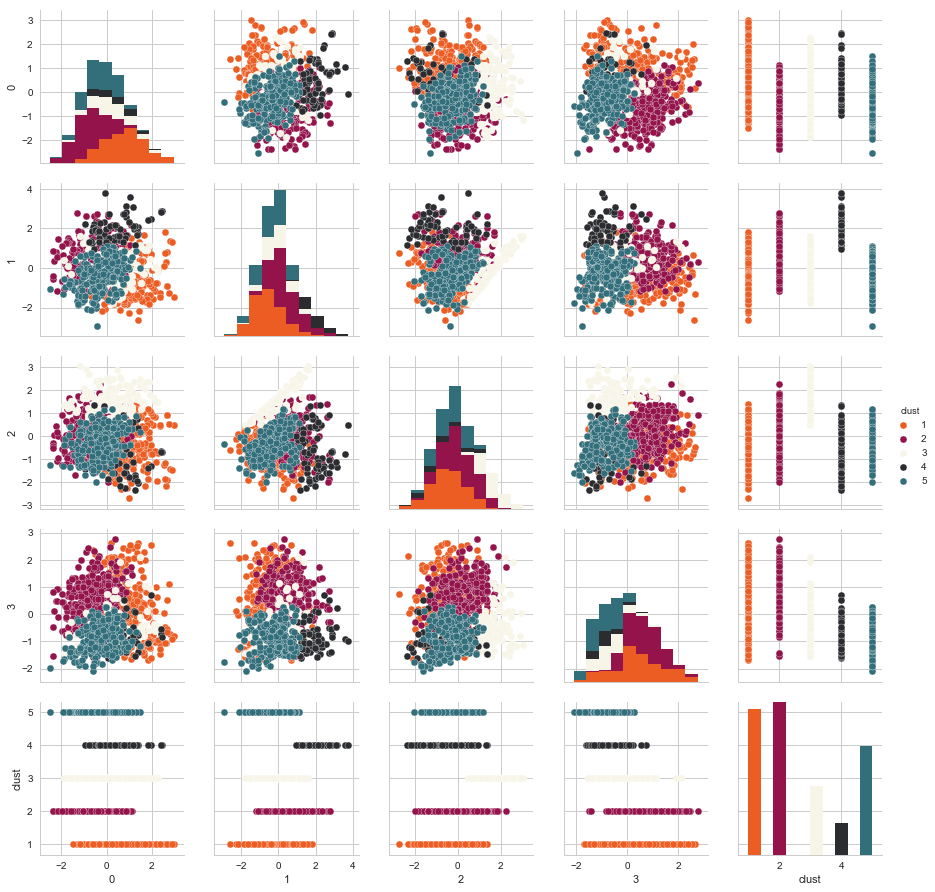

In [14]:
hpairdata = pd.DataFrame(
    PCA(n_components=4, whiten=True).fit_transform(X)
)
Z = linkage(hpairdata, 'ward')
f5 = fcluster(Z, 5, 'maxclust')
hpairdata['clust'] = f5
sns.pairplot(hpairdata,hue='clust')

Here we can confirm, as the dendrogram displayed that the customer have been partitioned into 2 larger clusters, 1 medium sized cluster and 2 smaller clusters

In [15]:
pd.Series(f5).value_counts()

2    301
1    287
5    213
3    136
4     63
dtype: int64

## 4.8 Final Clustering

Kmeans and Hierarchical Clustering both show 5 clusters to be the optimal number of clusters. Therefore we will run the algorithms with K=5 and append these to the main customer data and assess the means.

In [16]:
kmeans5 = KMeans(n_clusters=5)
kmeans5.fit(PCA(n_components=4, whiten=True).fit_transform(X))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [17]:
hdata5 = PCA(n_components=4, whiten=True).fit_transform(X)
Z = linkage(hdata5, 'ward')
fclust5 = fcluster(Z, 5, 'maxclust')
fclust5 = fclust5 - 1

In [18]:
customers['kmeans5'] = kmeans5.labels_
customers['hier5'] = fclust5
clustCustomers['kmeans5'] = kmeans5.labels_
clustCustomers['hier5'] = fclust5

Here we can pivot the original data with respect to the cluster and display the columns that have been clustered across.

In [19]:
kMeansClusterPivot = pd.concat(
    [customers.loc[:,clustCustomers.columns].pivot_table(
        index=['kmeans5'],
        aggfunc=[len]).rename(
            columns={'len':'count','averageNumberOfItemsPurchasedPerOrder':'count'}).iloc[:,1],
    customers.loc[:,clustCustomers.columns].pivot_table(
        index=['kmeans5'],
        aggfunc=[np.mean])],axis=1)

kMeansClusterPivot

count                    mean                                        \
         count WeekendOrdersProportion averageNumberOfItemsPurchasedPerOrder   
kmeans5                                                                        
0        204.0                0.272343                              5.108494   
1        209.0                0.069479                             17.274747   
2        243.0                0.249889                             10.686690   
3        132.0                0.676862                             21.063314   
4        212.0                0.237665                             20.096092   

                                                                              \
        averageOrdersPerStore averageProportionOfOrderDifferenceOfStoreTotal   
kmeans5                                                                        
0                    2.725621                                       0.100903   
1                    3.675439                                       0.005742   
2                    9.529747                                       0.008832   
3                    3.961111                                       0.015026   
4                    3.675234                                       0.140182   

                                                                           \
        averageProportionOfOrderSizeOfStoreTotal averageUniquenessOfOrder   
kmeans5                                                                     
0                                       0.072469                 0.632704   
1                                       0.002243                 0.720022   
2                                       0.003781                 0.504037   
3                                       0.005672                 0.703657   
4                                       0.088391                 0.563147   

                                                                          \
            hier5 itemsPurchasedWeekendProportion ordersPerUniqueProduct   
kmeans5                                                                    
0        0.200980                        0.285964               0.379472   
1        1.976077                        0.043650               0.141444   
2        2.786008                        0.258868               0.221009   
3        1.969697                        0.739958               0.116443   
4        1.051887                        0.244537               0.096726   

                                                                              \
        proportionOfProductRangePurchased proportionOfTotalItemsPurchasedOne   
kmeans5                                                                        
0                                0.001943                           0.797779   
1                                0.003496                           0.749520   
2                                0.006226                           0.770385   
3                                0.004290                           0.700045   
4                                0.007918                           0.750404   

                                                               \
        totalItemsPurchasedWeekday totalItemsPurchasedWeekend   
kmeans5                                                         
0                        34.553922                  13.887255   
1                        92.114833                   4.124402   
2                       141.489712                  50.382716   
3                        29.416667                  92.818182   
4                       174.070755                  58.783019   

                                                                          \
        totalNumberOfItemsPurchased totalShoppingOrders totalStoreOrders   
kmeans5                                                                    
0                         48.441176            9.558824         9.558824   
1                         96.239234

In [20]:
hierClusterPivot = pd.concat(
    [customers.loc[:,clustCustomers.columns].pivot_table(
        index=['hier5'],
        aggfunc=[len]).rename(
            columns={'len':'count','averageNumberOfItemsPurchasedPerOrder':'count'}).iloc[:,1],
     customers.loc[:,clustCustomers.columns].pivot_table(
         index=['hier5'],
         aggfunc=[np.mean])],axis=1)

hierClusterPivot

count                    mean                                        \
       count WeekendOrdersProportion averageNumberOfItemsPurchasedPerOrder   
hier5                                                                        
0      287.0                0.296503                              5.362632   
1      301.0                0.267446                             17.814758   
2      136.0                0.012619                             22.915165   
3       63.0                0.702124                             30.595350   
4      213.0                0.276927                             11.008744   

                                                                            \
      averageOrdersPerStore averageProportionOfOrderDifferenceOfStoreTotal   
hier5                                                                        
0                  2.946376                                       0.069960   
1                  4.591124                                       0.108162   
2                  4.477941                                       0.013436   
3                  4.455026                                       0.006177   
4                  8.566823                                       0.003665   

                                                                         \
      averageProportionOfOrderSizeOfStoreTotal averageUniquenessOfOrder   
hier5                                                                     
0                                     0.048990                 0.680489   
1                                     0.066475                 0.553980   
2                                     0.008252                 0.651713   
3                                     0.003115                 0.644913   
4                                     0.001273                 0.577448   

                                                                        \
      itemsPurchasedWeekendProportion   kmeans5 ordersPerUniqueProduct   
hier5                                                                    
0                            0.313593  0.794425               0.356149   
1                            0.281818  3.199336               0.114280   
2                            0.003353  1.220588               0.091482   
3                            0.743714  2.920635               0.062958   
4                            0.271090  1.868545               0.204388   

                                                                            \
      proportionOfProductRangePurchased proportionOfTotalItemsPurchasedOne   
hier5                                                                        
0                              0.001845                           0.787421   
1                              0.007820                           0.754111   
2                              0.004890                           0.734256   
3                              0.005825                           0.680948   
4                              0.004552                           0.762236   

                                                             \
      totalItemsPurchasedWeekday totalItemsPurchasedWeekend   
hier5                                                         
0                      32.282230                  14.202091   
1                     160.883721                  71.521595   
2                     148.183824                   0.977941   
3                      49.396825                 118.746032   
4                      96.305164                  34.901408   

                                                                        \
      totalNumberOfItemsPurchased totalShoppingOrders totalStoreOrders   
hier5                                                                    
0                       46.484321            8.766551         8.756098   
1                      232.405316           14.514950        14.089701   
2                      149.161765            6.720588         5

## 4.9 Comparison Tests

### 4.9.1 Summary

Here we have 5 clusters based on the two algorithms and we have used. We can compare the two approaches by using statistical analyses to see which approach better clusters the data. 

We could use t-tests to assess the difference in means betweens samples, however running a number of t-tests increases the chance to making a Type I error (incorrect rejection of a true null hypothesis - the differences are not the same)

This is because the t-test only looks at comparing the means of two sample means without taking into account the other samples.

The chance of making a type 1 error increases with the number of clusters we have. This is known as the Family-Wise Type 1 Error Rate.

In [21]:
def f(x): #factorial recursive-function
    if x==1:
        return 1
    return x * f(x-1)

In [22]:
nClusters = len(set(customers.kmeans5))
print("Number Of Clusters",nClusters,"\nFamily-Wise Type 1 Error Rate:",1 - ((1-0.05)**(((f(nClusters)) / ((f(2))*(f(nClusters-2)))))))


Number Of Clusters 5 
Family-Wise Type 1 Error Rate: 0.4012630607616213


Error too high! New measure required.

To account for this error, we use an anova test to validate the clusters.

We will use the F-score as a metric to evaluate each of the approaches.

We will then assess which clusters reject the null hypothesis by using a tukeys HSD a multi comparison test that reduces the chance of commiting a type 1 error.

### 4.9.2 ANOVA F-Scores and P-Values

In [23]:
from scipy.stats import stats

Here we calculate the average F-scores and p-values for each of the clustering algorithms in order to see which alogrithm performs better.

In [24]:
kmeansfScores = dict()
for _column in customers.loc[:,mainColoumns].columns:
    c0,c1,c2,c3,c4 = [customers[customers.kmeans5==i].loc[:,_column] for i in range(nClusters)]
    try:
        f = stats.f_oneway(c0,c1,c2,c3,c4)
        if np.isnan(f[1]):
            kmeansfScores[str(_column)] = (0,0)
        else:
            kmeansfScores[str(_column)] = f
    except:
        kmeansfScores[str(_column)] = (0,0)

In [25]:
hierfScores = dict()
for _column in customers.loc[:,mainColoumns].columns:
    c0,c1,c2,c3,c4 = [customers[customers.hier5==i].loc[:,_column] for i in range(nClusters)]
    try:
        f = stats.f_oneway(c0,c1,c2,c3,c4)
        if np.isnan(f[1]):
            hierfScores[str(_column)] = (0,0)
        else:
            hierfScores[str(_column)] = f
    except:
        hierfScores[str(_column)] = (0,0)

Here we see that the F-Score for K-Means is much larger than the Hierarchical method, resulting in a smaller average p-value

In [26]:
print('Kmeans Scores')
print("Average F-score: {} \nAverage p-value: {}".format(np.mean([v[0] for k,v in kmeansfScores.items() if np.isinf(v[0])==False]),np.mean([v[1] for k,v in kmeansfScores.items()])))


Kmeans Scores
Average F-score: 113.24518905699318 
Average p-value: 8.909093535435201e-08


In [27]:
print('Kmeans Scores')
print("Average F-score: {} \nAverage p-pvalue: {}".format(np.mean([v[0] for k,v in hierfScores.items() if np.isinf(v[0])==False]),np.mean([v[1] for k,v in hierfScores.items()])))


Kmeans Scores
Average F-score: 76.2977577902802 
Average p-pvalue: 8.714340572739136e-07


In [28]:
for k,v in kmeansfScores.items():
    print(k,"-")
    print("\tF-Score:", v[0])
    print("\tp-value:", v[1])
    print("*"*100)

totalItemsPurchasedWeekend -
	F-Score: 66.0584208182
	p-value: 1.37055896779e-49
****************************************************************************************************
averageNumberOfItemsPurchasedPerOrder -
	F-Score: 100.575227389
	p-value: 6.22747909519e-72
****************************************************************************************************
totalNumberOfItemsPurchased -
	F-Score: 111.214711545
	p-value: 2.19955434988e-78
****************************************************************************************************
customerID -
	F-Score: 0
	p-value: 0
****************************************************************************************************
averageProportionOfOrderDifferenceOfStoreTotal -
	F-Score: 48.3846334689
	p-value: 3.24906089764e-37
****************************************************************************************************
averageProportionOfOrderSizeOfStoreTotal -
	F-Score: 49.5379410227
	p-value: 4.82167836524e-38
*******

## 4.10 Unsupervised Ensemble Modelling

### 4.10.1 Main ensembling

Here we can compare the clusters to see how well they match up in clustering customers. 

In [29]:
nClusters = 5
mat = np.zeros((nClusters,nClusters))
for i,j in zip(kmeans5.labels_,fclust5):
    mat[i,j] +=1
mat

array([[ 178.,   21.,    0.,    0.,    5.],
       [  43.,    4.,  118.,    3.,   41.],
       [  18.,   66.,   12.,    1.,  146.],
       [  43.,   13.,    0.,   57.,   19.],
       [   5.,  197.,    6.,    2.,    2.]])

In [30]:
np.sum([max(i) for i in mat]) / np.sum(mat)

0.69599999999999995

Looking at the results, we can see that the clusters agree on grouping about 70% of the clusters.

If we bag these models together we can try an ensemble model and see if we can increase our F-score.

The F-score for K-Means, is already relatively high and we can happily use the model on its own but we may be able to combine the benefits of each model into a single better performing model 

In [31]:
print('K-means Best Match Rate')
for i in range(nClusters):
    top, ind = max(mat[i]), list(mat[i]).index(max(mat[i]))
    print(i,"-",ind,"-", mat[i,ind] /sum(mat[i,]))

K-means Best Match Rate
0 - 0 - 0.872549019608
1 - 2 - 0.564593301435
2 - 4 - 0.600823045267
3 - 3 - 0.431818181818
4 - 1 - 0.929245283019


In [32]:
print('Hierarchical Best Match Rates')
for i in range(nClusters):
    top, ind = max([j[i] for j in mat]), list([j[i] for j in mat]).index(max([j[i] for j in mat]))
    print(i,"-",ind,"-", mat[ind,i] /sum([j[i] for j in mat]))

Hierarchical Best Match Rates
0 - 0 - 0.620209059233
1 - 4 - 0.654485049834
2 - 1 - 0.867647058824
3 - 3 - 0.904761904762
4 - 2 - 0.68544600939


Here we can see which classes match up well with respect to the other algorithm

In [33]:
i=3
list(mat[i]).index(max(mat[i]))

3

In [34]:
res = []
# for k in range(nClusters):
#     for i, j in zip(kmeans5.labels_,fclust5):
#         if i==k and j==list(mat[i]).index(max(mat[i])):
#             res.append(k)
#         else:
    
for i,j in zip(kmeans5.labels_,fclust5):
    if i==0 and j==list(mat[i]).index(max(mat[i])):
        res.append(0)
    elif i==1 and j==list(mat[i]).index(max(mat[i])):
        res.append(1)
    elif i==2 and j==list(mat[i]).index(max(mat[i])):
        res.append(2)
    elif i==3 and j==list(mat[i]).index(max(mat[i])):
        res.append(3)
    elif i==4 and j==list(mat[i]).index(max(mat[i])):
        res.append(4)
    else:
        res.append(-1)

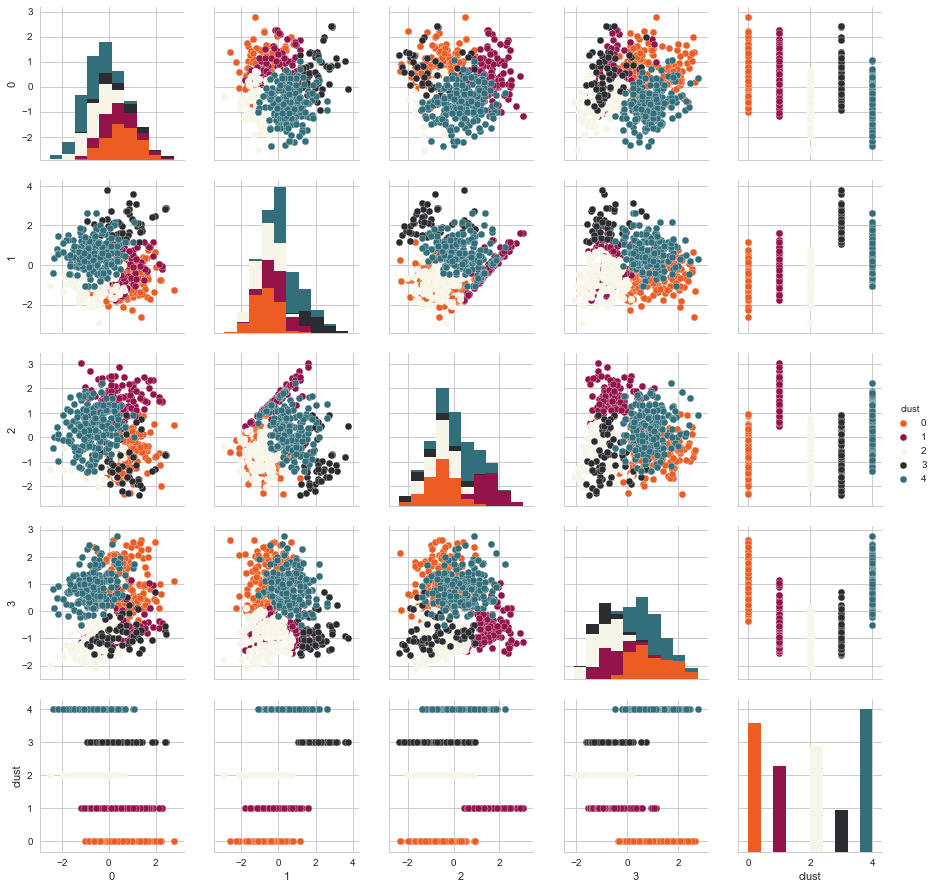

In [35]:
ensembledata = pd.DataFrame(PCA(n_components=4, whiten=True).fit_transform(X))
ensembledata['clust'] = res
sns.pairplot(ensembledata[ensembledata.clust!=-1],hue='clust',diag_kind='hist')

In [36]:
customers['ensemble1'] = res
clustCustomers['ensemble1'] = res

Here we can see that ther clusters look better when both models are used, and removing the other values that the model does not agree on as 'noise'.

In [37]:
ensemblefScores = dict()
for _column in customers.loc[:,mainColoumns].columns:
    c0,c1,c2,c3,c4 = [customers[customers.ensemble1==i].loc[:,_column] for i in range(nClusters)]
    try:
        f = stats.f_oneway(c0,c1,c2,c3,c4)
        if np.isnan(f[1]):
            ensemblefScores[str(_column)] = (0,0)
        else:
            ensemblefScores[str(_column)] = f
    except:
        ensemblefScores[str(_column)] = (0,0)

In [38]:
print('ensemble Scores')
print("Average F-score: {} \nAverage p-value: {}".format(
    np.mean([v[0] for k,v in ensemblefScores.items() if np.isinf(v[0])==False]),
    np.mean([v[1] for k,v in ensemblefScores.items()])))


ensemble Scores
Average F-score: 82.23936699527111 
Average p-value: 3.1291815167264884e-08


The F-Score performs better than the Hierarchical model on its own but weaker than the K-Means model on its own.


In [39]:
mixData = pd.DataFrame(PCA(n_components=4, whiten=True).fit_transform(X))
mixData['kmeans5'] = kmeans5.labels_
mixData['hier5'] = fclust5
mixData['ensemble1'] = res
mixData.head()

,0,1,2,3,kmeans5,hier5,ensemble1
0,1.593875,-0.911507,-0.569784,-1.349757,1,0,-1
1,0.610012,-0.015653,-0.505168,-1.397802,2,4,2
2,-0.189460,-0.116780,0.666579,0.181995,4,1,4
3,-0.373621,-0.796029,-0.324658,0.739653,0,0,0
4,0.575819,0.694033,0.390497,-0.886397,1,4,-1


### 4.10.2 Enhancements

We can develop the model further by clustering the remaining data points based on the euclidean distance of the means of the clusters. Firstly we calculate the centers for both the hierarchical model points and then we take the centroids of the kmeans model. We take the centroids based on our PCA-reduced data.

In [40]:
kCenters = kmeans5.cluster_centers_
hCenters = np.zeros((5,4))
for i in range(nClusters):
    hCenters[i] += np.mean(mixData[mixData.hier5==i],axis=0)[:4]

In [41]:
kCenters

array([[ 0.53261338, -0.63232965, -0.4729914 ,  0.96946417],
       [ 0.61608524, -0.20034596,  1.14649725, -0.60844953],
       [-0.77330209, -0.52098426, -0.40706436, -0.68266529],
       [ 0.73659283,  1.39424115, -0.9216132 , -0.63224219],
       [-0.6921358 ,  0.53503255,  0.36529198,  0.843108  ]])

In [42]:
hCenters

array([[ 0.7661461 , -0.5627572 , -0.45717617,  0.45463247],
       [-0.72377237,  0.39924238,  0.10005523,  0.62747208],
       [ 0.21186628, -0.05986666,  1.5712056 , -0.5715723 ],
       [ 0.44556658,  1.98693263, -0.6620914 , -0.81967564],
       [-0.27658664, -0.35537808, -0.3327665 , -0.89190243]])

In [43]:
cents = pd.DataFrame(np.vstack([kCenters,hCenters]))
cents['hue'] = np.array([[0],[0],[0],[0],[0],[1],[1],[1],[1],[1]])

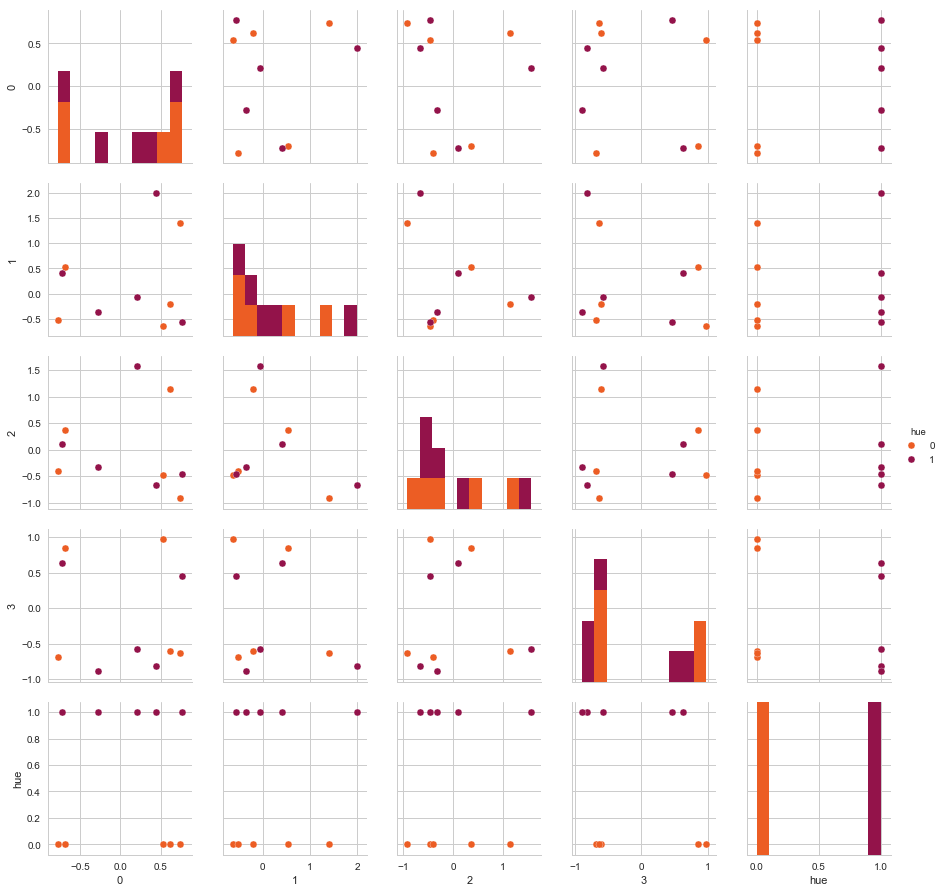

In [44]:
sns.pairplot(cents,hue='hue')

Here we can plot the centers of each of the clusters. Here we can see that for Components 1,2 and 3 the centers behave similarly, however for components 0 and 1, we can see that they behave less similar.

Here we can build a function that can calculate the distances between the predicted centeroids for each of the clusters and returns the closest cluster value.

In [45]:
def classClosest(row):
    if row['ensemble1']!=-1:
        return row['ensemble1']
    
    kdist = np.sqrt((np.sum(row[:4] - kCenters[int(row[4])]))**2)
    hdist = np.sqrt((np.sum(row[:4] - hCenters[int(row[5])]))**2)
    
    if kdist>hdist:
        return row['hier5']
    else:
        return row['kmeans5']

In [46]:
mixData['finalClust'] = mixData.apply(lambda x: int(classClosest(x)), axis=1)

### 4.10.3 Complete Ensemble

In [47]:
customers['finalClust'] = mixData.finalClust
clustCustomers['finalClust'] = mixData.finalClust

In [48]:
finalfScores = dict()
for _column in customers.loc[:,mainColoumns].columns:
    c0,c1,c2,c3,c4 = [customers[customers.finalClust==i].loc[:,_column] for i in range(nClusters)]
    try:
        f = stats.f_oneway(c0,c1,c2,c3,c4)
        if np.isnan(f[1]):
            finalfScores[str(_column)] = (0,0)
        else:
            finalfScores[str(_column)] = f
    except:
        finalfScores[str(_column)] = (0,0)

In [49]:
print('ensemble Scores')
print("Average F-score: {} \nAverage p-value: {}".format(np.mean([v[0] for k,v in finalfScores.items() if np.isinf(v[0])==False]),np.mean([v[1] for k,v in finalfScores.items()])))


ensemble Scores
Average F-score: 92.37862059958887 
Average p-value: 8.939183027551591e-07


Here we can see that the Ensemble model scores a higher F-Score however, the average p-value increases slightly. Using just the F-Score I will continue to use the results of the ensemble method as the p-values across all models are really small across them all

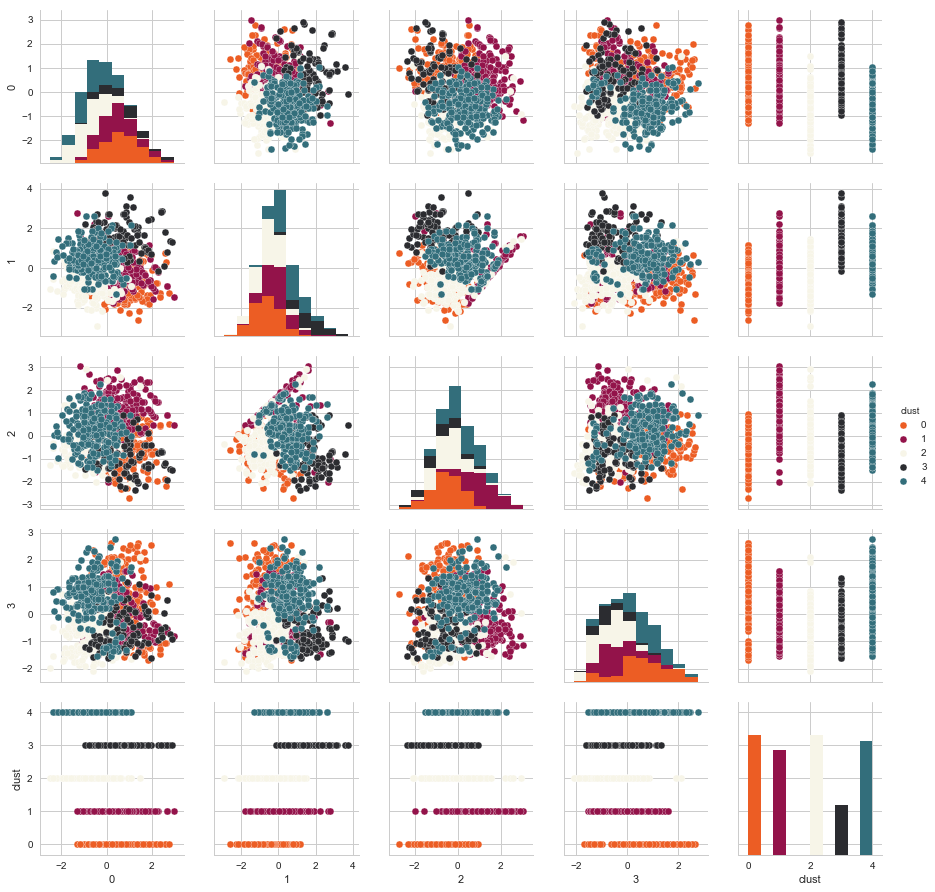

In [50]:
finalData = pd.DataFrame(PCA(n_components=4, whiten=True).fit_transform(X))
finalData['clust'] = mixData.finalClust
sns.pairplot(finalData,hue='clust',diag_kind='hist')

In [51]:
finalClusterPivot = pd.concat(
    [customers.loc[:,clustCustomers.columns].pivot_table(
        index=['finalClust'], aggfunc=[len]).rename(
            columns={'len':'count','averageNumberOfItemsPurchasedPerOrder':'count'}).iloc[:,1],
     customers.loc[:,clustCustomers.columns].pivot_table(
         index=['finalClust'],
         aggfunc=[np.mean])],axis=1)
finalClusterPivot

count                    mean  \
            count WeekendOrdersProportion   
finalClust                                  
0           235.0                0.289080   
1           207.0                0.095059   
2           236.0                0.247020   
3            98.0                0.683423   
4           224.0                0.257366   

                                                                        \
           averageNumberOfItemsPurchasedPerOrder averageOrdersPerStore   
finalClust                                                               
0                                       5.014259              2.963680   
1                                      18.485162              3.573349   
2                                      11.163713              9.617494   
3                                      24.185691              3.627891   
4                                      19.109537              3.930929   

                                                           \
           averageProportionOfOrderDifferenceOfStoreTotal   
finalClust                                                  
0                                                0.084585   
1                                                0.013318   
2                                                0.012443   
3                                                0.018207   
4                                                0.126237   

                                                                              \
           averageProportionOfOrderSizeOfStoreTotal averageUniquenessOfOrder   
finalClust                                                                     
0                                          0.059896                 0.644661   
1                                          0.007324                 0.709556   
2                                          0.006995                 0.502479   
3                                          0.006899                 0.710440   
4                                          0.079197                 0.570203   

                                                                          \
           ensemble1     hier5 itemsPurchasedWeekendProportion   kmeans5   
finalClust                                                                 
0          -0.242553  0.068085                        0.308106  0.459574   
1           0.140097  1.980676                        0.072329  0.990338   
2           0.855932  2.860169                        0.258200  2.033898   
3           1.326531  2.183673                        0.739888  2.969388   
4           3.397321  1.334821                        0.263658  3.816964   

                                                                     \
           ordersPerUniqueProduct proportionOfProductRangePurchased   
finalClust                                                            
0                        0.380009                          0.001913   
1                        0.110672                          0.004016   
2                        0.222446                          0.006224   
3                        0.093631                          0.004549   
4                        0.101210                          0.007541   

                                                                          \
           proportionOfTotalItemsPurchasedOne totalItemsPurchasedWeekday   
finalClust                                                                 
0                                    0.790406                  33.093617   
1                                    0.746838                  98.628019   
2                                    0.771342                 142.686441   
3                                    0.696848                  32.969388   
4                                    0.747426                 162.370536   

                                                                   \
           totalItemsPurchasedWeekend totalNumberOfItemsPurchased   
fin

Here we can see that the ensemble has distributed the customers relatively evenly.

## 4.11 Tukeys HSD

Now that we have our clusters we can run multi-comparitive tests. following a good F-score we can calculate whether the differences between cluster means are significantly different. Here we can use Tukey's HSD, which takes into account other samples are reduces our chance of making a Type I error as mentioned before.

In [52]:
import statsmodels.stats.multicomp as multi

In [53]:
tukeyScores = dict()
for _column in customers.loc[:,mainColoumns].columns:
    x = np.array(customers.loc[:,_column])
    try:
        tukeyScores[str(_column)] = multi.MultiComparison(x,np.array(customers.finalClust)).tukeyhsd()
    except:
        tukeyScores[str(_column)] = 0

In [54]:
for _col in tukeyScores.keys():
    print(_col)
    try:
        print(tukeyScores[_col].summary())
    except:
        print('Not Available')
    print('*'*100)

totalItemsPurchasedWeekend
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
  0      1    -2.6397  -18.0303 12.7508  False 
  0      2    35.0665  20.1872  49.9458   True 
  0      3    80.3671  60.9521  99.7821   True 
  0      4    43.4838   28.407  58.5606   True 
  1      2    37.7062  22.3309  53.0815   True 
  1      3    83.0068  63.2092  102.8045  True 
  1      4    46.1235   30.557   61.69    True 
  2      3    45.3006  25.8977  64.7035   True 
  2      4     8.4173  -6.6439  23.4785  False 
  3      4    -36.8833 -56.4381 -17.3285  True 
-----------------------------------------------
****************************************************************************************************
averageNumberOfItemsPurchasedPerOrder
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    13

In [55]:
pd.concat(
    [customers.loc[:,clustCustomers.columns].pivot_table(
        index=['finalClust'],
        aggfunc=[len]).rename(
        columns={'len':'count','averageNumberOfItemsPurchasedPerOrder':'count'}).iloc[:,1],
     customers.loc[:,clustCustomers.columns].pivot_table(
         index=['finalClust'],
         aggfunc=[np.mean])],axis=1)


count                    mean  \
            count WeekendOrdersProportion   
finalClust                                  
0           235.0                0.289080   
1           207.0                0.095059   
2           236.0                0.247020   
3            98.0                0.683423   
4           224.0                0.257366   

                                                                        \
           averageNumberOfItemsPurchasedPerOrder averageOrdersPerStore   
finalClust                                                               
0                                       5.014259              2.963680   
1                                      18.485162              3.573349   
2                                      11.163713              9.617494   
3                                      24.185691              3.627891   
4                                      19.109537              3.930929   

                                                           \
           averageProportionOfOrderDifferenceOfStoreTotal   
finalClust                                                  
0                                                0.084585   
1                                                0.013318   
2                                                0.012443   
3                                                0.018207   
4                                                0.126237   

                                                                              \
           averageProportionOfOrderSizeOfStoreTotal averageUniquenessOfOrder   
finalClust                                                                     
0                                          0.059896                 0.644661   
1                                          0.007324                 0.709556   
2                                          0.006995                 0.502479   
3                                          0.006899                 0.710440   
4                                          0.079197                 0.570203   

                                                                          \
           ensemble1     hier5 itemsPurchasedWeekendProportion   kmeans5   
finalClust                                                                 
0          -0.242553  0.068085                        0.308106  0.459574   
1           0.140097  1.980676                        0.072329  0.990338   
2           0.855932  2.860169                        0.258200  2.033898   
3           1.326531  2.183673                        0.739888  2.969388   
4           3.397321  1.334821                        0.263658  3.816964   

                                                                     \
           ordersPerUniqueProduct proportionOfProductRangePurchased   
finalClust                                                            
0                        0.380009                          0.001913   
1                        0.110672                          0.004016   
2                        0.222446                          0.006224   
3                        0.093631                          0.004549   
4                        0.101210                          0.007541   

                                                                          \
           proportionOfTotalItemsPurchasedOne totalItemsPurchasedWeekday   
finalClust                                                                 
0                                    0.790406                  33.093617   
1                                    0.746838                  98.628019   
2                                    0.771342                 142.686441   
3                                    0.696848                  32.969388   
4                                    0.747426                 162.370536   

                                                                   \
           totalItemsPurchasedWeekend totalNumberOfItemsPurchased   
fin

Now that we have our clusters and their means, we can use the results of Tukey's HSD to determine whether we develop strategies based on the clusters with respect to a particular feature.

For example, If we look at 'averageNumberOfItemsPurchasedPerOrder' we can see that cluster 0 have the lowest number of items in their basket amongst the other clusters. Referencing the results of the the Tukey's HSD calculations, we can see that cluster 0 is significantly different to all the other clusters and we can reject the null hypothesis stating that they are not. If we then wish to engage in tageted marketing campaigns that promote additional items into baskets, we can feel confident that cluster 0 would be the best customers to target and we can relocate resources accordingly.

## 4.12 Exports

Here we can extract the clusters that the customers belong to based on our analysis and save them for later analysis

In [56]:
customerClusters = customers.iloc[:,[0,-1]]

In [57]:
customerClusters.to_csv('datasets/customerClusters.csv')

# END

In [59]:
customers.head()

,customerID,totalShoppingOrders,totalStoreOrders,totalWebOrders,storeOrdersProportion,webOrdersProportion,totalNumberOfItemsPurchased,averageNumberOfItemsPurchasedPerOrder,proportionOfTotalItemsPurchasedOne,totalWeekendOrders,totalWeekdayOrders,WeekendOrdersProportion,WeekdayOrdersProportion,totalItemsPurchasedWeekend,totalItemsPurchasedWeekday,itemsPurchasedWeekendProportion,itemsPurchasedWeekdayProportion,proportionOfProductRangePurchased,ordersPerUniqueProduct,numberOfDifferentStoresPurchased,averageOrdersPerStore,proportionOfOrdersWithRepeatedProductsPurchased,averageUniquenessOfOrder,averageBusyStore,averageProportionOfOrderSizeOfStoreTotal,averageProportionOfOrderDifferenceOfStoreTotal,kmeans5,hier5,ensemble1,finalClust
0,0072c7c58d8c992912abf1a5879094f3e291e09491fd9b...,4.0,4.0,0.0,1.0,0.0,13.0,3.250000,0.615385,1,3,0.250000,0.750000,4,9,0.307692,0.692308,0.000518,0.444444,1,4.000000,0.500000,0.854167,2.000000,0.000130,0.000369,1,0,-1,0
1,0079b5c1305069af07beb6f305cfa5d0792a856d31e105...,6.0,6.0,0.0,1.0,0.0,54.0,9.000000,0.462963,2,4,0.333333,0.666667,21,33,0.388889,0.611111,0.001785,0.193548,1,6.000000,0.833333,0.672222,2.000000,0.000326,0.000815,2,4,2,2
2,007b7fed2ec3129b8a1e222baac858a8e56795ad03eb81...,9.0,9.0,0.0,1.0,0.0,129.0,14.333333,0.883721,2,7,0.222222,0.777778,5,124,0.038760,0.961240,0.005297,0.097826,3,3.000000,0.888889,0.571304,1.666667,0.003804,0.019363,4,1,4,4
3,011fef265b7a817045afd1b919d7a5b1858da3e4f502ae...,16.0,16.0,0.0,1.0,0.0,97.0,6.062500,1.000000,2,14,0.125000,0.875000,25,72,0.257732,0.742268,0.004146,0.222222,6,2.666667,0.875000,0.548478,0.437500,0.011734,0.023637,0,0,0,0
4,018e2cc1b45c8c1d21a2d1d3b6e62f4995a92b31660dfa...,4.0,4.0,0.0,1.0,0.0,78.0,19.500000,0.820513,2,2,0.500000,0.500000,10,68,0.128205,0.871795,0.003570,0.064516,1,4.000000,1.000000,0.670094,2.000000,0.000780,0.002582,1,4,-1,1
